## Results for Möstl et al. (2026) ICMECAT paper

script to produce paper results for the ICMECAT paper Möstl et al. 2026, to be submitted to ApJ

- uses environment dro, see /envs/env_dro.yml
 
- uses ICMECAT version 2.3, released 2025 October 15 https://doi.org/10.6084/m9.figshare.6356420.v24 / this is figshare version 24

- additionally reads in Solar Orbiter and Parker Solar Probe data from data files, available in the figshare repository version 27 https://doi.org/10.6084/m9.figshare.11973693.v27


---
### papers

- **Salman+ 2024** PSP events, but before Sep 2022 https://iopscience.iop.org/article/10.3847/1538-4357/ad320c
- **Mann+ 2023** A&A solar wind model https://www.aanda.org/articles/aa/full_html/2023/11/aa45050-22/aa45050-22.html
- **Livingston+ 2006** sunspot field strength at 1 solar radii:https://link.springer.com/article/10.1007/s11207-006-0265-4 on the order of kiloGauss or 10^8 nT (1 Gauss is 10^5 nT)
- **Trelles Arjona+ 2021**, https://iopscience.iop.org/article/10.3847/2041-8213/ac0af2#:~:text=On%20average%2C%20the%20quiet%2DSun,a%20strength%20of%2046%20G.


---
### Ideas 

- maybe look at power laws for each B component
- total ICME B field (sheath + MO)
- solar cycle dependence




In [1]:
import pickle 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import datetime
import os
import scipy
import copy
import astropy.constants as const
from sunpy.time import parse_time
from scipy.optimize import curve_fit


#one solar radius in au
rs=(const.R_sun/const.au).value
print(f'1 solar radii in au {rs:.5f}')
scale=1/rs #scaling factor au to Rs
print(f'1 au in solar radii {scale:.5f}')


#convert to script
os.system('jupyter nbconvert --to script moestl_icmecat_results.ipynb')
print(os.system('pwd'))


#define powerlaw function
def powerlaw(x, a, b):
    return a*x**b


1 solar radii in au 0.00465
1 au in solar radii 215.03216


[NbConvertApp] Converting notebook moestl_icmecat_results.ipynb to script


/Users/chris/python/icmecat_paper_2026
0


[NbConvertApp] Writing 57583 bytes to moestl_icmecat_results.py


## load data

In [2]:
#load icmecat as pandas dataframe
file='icmecat/HELIO4CAST_ICMECAT_v23_pandas.p'
[ic,h,p]=pickle.load( open(file, 'rb'))   

ic_mo_start_time_num=parse_time(ic.mo_start_time) #convert to matplotlib time

#get indices for each target
imes=np.where(ic.sc_insitu=='MESSENGER')[0]
ivex=np.where(ic.sc_insitu=='VEX')[0]
imav=np.where(ic.sc_insitu=='MAVEN')[0]
ijun=np.where(ic.sc_insitu=='Juno')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]
iuly=np.where(ic.sc_insitu=='ULYSSES')[0]

iwin=np.where(ic.sc_insitu=='Wind')[0]
ista=np.where(ic.sc_insitu=='STEREO-A')[0]
ipsp=np.where(ic.sc_insitu=='PSP')[0]
isol=np.where(ic.sc_insitu=='SolarOrbiter')[0]
ibep=np.where(ic.sc_insitu=='BepiColombo')[0]

## load PSP data
print('load PSP data RTN')
filepsp='psp_2018_now_rtn.p'
[psp,hpsp]=pickle.load(open('data/'+filepsp, "rb" ) ) 
print('done')

## load SolO data
print('load Solar Orbiter RTN')
filesolo='solo_2020_now_rtn.p'
[solo,hsolo]=pickle.load(open('data/'+filesolo, "rb" ) )    
print('done')

## load positions file (70 MB)
[psppos, bepi, solopos, sta, juice, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune,l4,l5]=pickle.load( open( 'positions/positions_2020_all_HEEQ_1h_rad_cm.p', "rb" ) ) 
print('all data loaded')

load PSP data RTN
done
load Solar Orbiter RTN
done
all data loaded


### Basic ICMECAT statistics

In [3]:
print('Number of events in ICMECAT', len(ic))
print()
print(f'minimum of PSP distance {np.min(psppos.r):.4f}')
print()
print('earliest and latest event time')
print(np.min(ic.icme_start_time))
print(np.max(ic.icme_start_time))
print()
print(f'How many events: {len(ic.icmecat_id)}')
ourevents=791+15 
print('events from us, MOESTL or WEILER, look up from catalog online: ', ourevents)
print('percentage of our events:')
print(ourevents/np.size(ic.icmecat_id)*100)
print('events without ulysses', len(ic)-len(iuly))

print()

#get indices for each target
imes=np.where(ic.sc_insitu=='MESSENGER')[0]
ivex=np.where(ic.sc_insitu=='VEX')[0]
iwin=np.where(ic.sc_insitu=='Wind')[0]
imav=np.where(ic.sc_insitu=='MAVEN')[0]
ijun=np.where(ic.sc_insitu=='Juno')[0]

ista=np.where(ic.sc_insitu=='STEREO-A')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]
ipsp=np.where(ic.sc_insitu=='PSP')[0]
isol=np.where(ic.sc_insitu=='SolarOrbiter')[0]
ibep=np.where(ic.sc_insitu=='BepiColombo')[0]
iuly=np.where(ic.sc_insitu=='ULYSSES')[0]

print('closest events of PSP to sun_')
print('PSP')
psp_ids=ic.sort_values('mo_sc_heliodistance')['icmecat_id']
psp_dist=ic.sort_values('mo_sc_heliodistance')['mo_sc_heliodistance']
print(psp_ids[0:15])
print(psp_dist[0:15])



#sorted indices for psp
sortpsp=np.argsort(ic.mo_sc_heliodistance[ipsp])
#print(sortpsp[0:10])
#print(ic.icmecat_id[ipsp][sortpsp])
#print()

#print('SolO')
#print(np.sort(ic.mo_sc_heliodistance[isol])[0:15])

print('0.0685 au in solar radii', 0.0685/rs)


print('PSP time:',psp.time[0],psp.time[-1])
print('lastest SolO time:',solo.time[0],solo.time[-1])



Number of events in ICMECAT 1976

minimum of PSP distance 0.0458

earliest and latest event time
1990-12-11 04:00:00
2025-08-10 05:17:00

How many events: 1976
events from us, MOESTL or WEILER, look up from catalog online:  806
percentage of our events:
40.78947368421053
events without ulysses 1697

closest events of PSP to sun_
PSP
463     ICME_PSP_MOESTL_20220905_01
495     ICME_PSP_MOESTL_20220602_01
625     ICME_PSP_MOESTL_20210430_01
66      ICME_PSP_MOESTL_20241222_01
104     ICME_PSP_MOESTL_20241004_01
408     ICME_PSP_MOESTL_20230313_01
315     ICME_PSP_MOESTL_20230922_01
723     ICME_PSP_MOESTL_20181111_01
307     ICME_PSP_MOESTL_20231003_01
227     ICME_PSP_MOESTL_20240324_01
724     ICME_PSP_MOESTL_20181030_01
458     ICME_PSP_MOESTL_20220912_01
107    ICME_SOLO_MOESTL_20240930_01
400    ICME_SOLO_MOESTL_20230410_01
103    ICME_SOLO_MOESTL_20241004_01
Name: icmecat_id, dtype: object
463    0.0685
495    0.0706
625    0.0892
66     0.1415
104    0.2110
408    0.2281
315    0.

### Figure (1) for ICMECAT times and distance

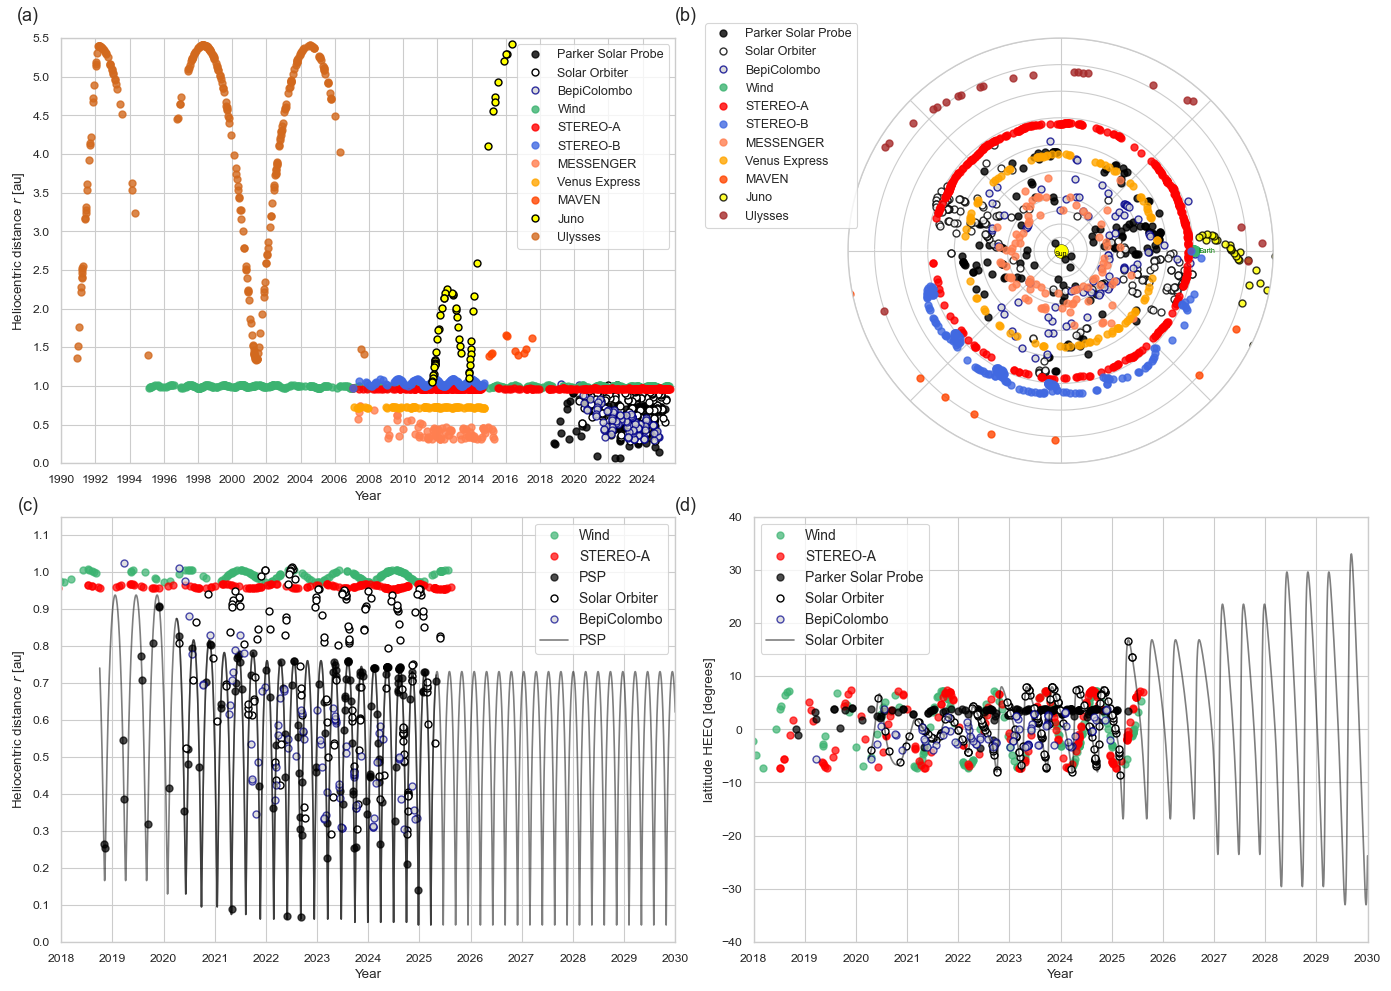

In [4]:
sns.set_context("paper")     
sns.set_style('whitegrid')

fig=plt.figure(3,figsize=(14,10),dpi=100)

###########################################################
ax1=plt.subplot(221)
ms=5
al=0.8

ax1.plot(ic.mo_start_time[ipsp],ic.mo_sc_heliodistance[ipsp],'o',c='black', alpha=al,ms=ms,label='Parker Solar Probe')
ax1.plot(ic.mo_start_time[isol],ic.mo_sc_heliodistance[isol],'o',c='black',markerfacecolor='white', alpha=1.0,ms=ms,label='Solar Orbiter')
ax1.plot(ic.mo_start_time[ibep],ic.mo_sc_heliodistance[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms,label='BepiColombo')
ax1.plot(ic.mo_start_time[iwin],ic.mo_sc_heliodistance[iwin],'o',c='mediumseagreen', alpha=al,ms=ms,label='Wind')
ax1.plot(ic.mo_start_time[ista],ic.mo_sc_heliodistance[ista],'o',c='red', alpha=al,ms=ms, label='STEREO-A')

ax1.plot(ic.mo_start_time[istb],ic.mo_sc_heliodistance[istb],'o',c='royalblue', alpha=al,ms=ms,label='STEREO-B')
ax1.plot(ic.mo_start_time[imes],ic.mo_sc_heliodistance[imes],'o',c='coral', alpha=al,ms=ms,label='MESSENGER')
ax1.plot(ic.mo_start_time[ivex],ic.mo_sc_heliodistance[ivex],'o',c='orange', alpha=al,ms=ms,label='Venus Express')
ax1.plot(ic.mo_start_time[imav],ic.mo_sc_heliodistance[imav],'o',c='orangered', alpha=al,ms=ms,label='MAVEN')
ax1.plot(ic.mo_start_time[ijun],ic.mo_sc_heliodistance[ijun],'o',c='black',markerfacecolor='yellow', alpha=1,ms=ms,label='Juno')
ax1.plot(ic.mo_start_time[iuly],ic.mo_sc_heliodistance[iuly],'o',c='chocolate', alpha=al,ms=ms,label='Ulysses')

ax1.set_ylabel('Heliocentric distance $r$ [au]')
ax1.set_xlabel('Year')

years = mdates.YearLocator(2)   
ax1.xaxis.set_major_locator(years)
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)

#ax1.tick_params(axis="x", labelsize=12)
#ax1.tick_params(axis="y", labelsize=12)

ax1.set_xlim([datetime.datetime(1990,1,1),datetime.datetime(2025,12,1)])
#ax1.legend(loc=1,fontsize=14)

ax1.set_yticks(np.arange(0,6,0.5))
ax1.set_ylim([0,5.5])
ax1.legend(loc='upper right', fontsize=9)


##############################################################

ax4=plt.subplot(222,projection='polar')

ax4.plot(np.radians(ic.mo_sc_long_heeq[ipsp]),ic.mo_sc_heliodistance[ipsp],'o',markersize=ms, c='black', alpha=al,label='Parker Solar Probe')
ax4.plot(np.radians(ic.mo_sc_long_heeq[isol]),ic.mo_sc_heliodistance[isol],'o',markersize=ms, c='black',markerfacecolor='white', alpha=al, label='Solar Orbiter')
ax4.plot(np.radians(ic.mo_sc_long_heeq[ibep]),ic.mo_sc_heliodistance[ibep],'o',markersize=ms, c='darkblue',markerfacecolor='lightgrey', alpha=al, label='BepiColombo')
ax4.plot(np.radians(ic.mo_sc_long_heeq[iwin]),ic.mo_sc_heliodistance[iwin],'o',markersize=ms, c='mediumseagreen', alpha=al, label='Wind')
ax4.plot(np.radians(ic.mo_sc_long_heeq[ista]),ic.mo_sc_heliodistance[ista],'o',markersize=ms, c='red', alpha=al, label='STEREO-A')
ax4.plot(np.radians(ic.mo_sc_long_heeq[istb]),ic.mo_sc_heliodistance[istb],'o',markersize=ms,c='royalblue', alpha=al,label='STEREO-B')
ax4.plot(np.radians(ic.mo_sc_long_heeq[imes]),ic.mo_sc_heliodistance[imes],'o',markersize=ms,c='coral', alpha=al,label='MESSENGER')
ax4.plot(np.radians(ic.mo_sc_long_heeq[ivex]),ic.mo_sc_heliodistance[ivex],'o',markersize=ms,c='orange', alpha=al,label='Venus Express')
ax4.plot(np.radians(ic.mo_sc_long_heeq[imav]),ic.mo_sc_heliodistance[imav],'o',markersize=ms,c='orangered', alpha=al, label='MAVEN')
ax4.plot(np.radians(ic.mo_sc_long_heeq[ijun]),ic.mo_sc_heliodistance[ijun],'o',markersize=ms,c='black',markerfacecolor='yellow',alpha=al,label='Juno')
ax4.plot(np.radians(ic.mo_sc_long_heeq[iuly]),ic.mo_sc_heliodistance[iuly],'o',markersize=ms,c='brown', alpha=al, label='Ulysses')


fsize=10
frame='HEEQ'
backcolor='white'
plt.rgrids((0.1,0.2,0.3,0.4,0.6,0.8,1.0,1.2, 1.4,1.6,1.8,2.0),('','0.2','','0.4','0.6','0.8','1.0','1.2','1.4','','',''),angle=180, fontsize=fsize-4,alpha=0.8, ha='center',color=backcolor,zorder=5)
plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'±180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), fmt='%d',ha='center',fontsize=fsize,color=backcolor, zorder=5, alpha=1.0)

ax4.set_ylim([0,1.6])
ax4.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
ax4.text(0,1.1,'Earth', color='green', ha='center',fontsize=fsize-5,verticalalignment='center')
ax4.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)
ax4.legend(bbox_to_anchor=(-0.35, 1.05),loc='upper left', fontsize=9)
#ax4.legend(loc='upper right', fontsize=9)


##############################################################
ax2=plt.subplot(223)

ms=5
al=0.7

ax2.plot(ic.mo_start_time[iwin],ic.mo_sc_heliodistance[iwin],'o',c='mediumseagreen', alpha=al,ms=ms,label='Wind')
ax2.plot(ic.mo_start_time[ista],ic.mo_sc_heliodistance[ista],'o',c='red', alpha=al,ms=ms,label='STEREO-A')
ax2.plot(ic.mo_start_time[ipsp],ic.mo_sc_heliodistance[ipsp],'o',c='black', alpha=al,ms=ms,label='PSP')
ax2.plot(ic.mo_start_time[isol],ic.mo_sc_heliodistance[isol],'o',c='black',markerfacecolor='white', alpha=1.0,ms=ms,label='Solar Orbiter')
ax2.plot(ic.mo_start_time[ibep],ic.mo_sc_heliodistance[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms,label='BepiColombo')

#from data
#psp
ax2.plot(psp.time,psp.r,'k-',alpha=0.5)   ###########******* dont double plot for the beginning ********
ax2.plot(psppos.time,psppos.r,'k-',alpha=0.5, label='PSP')

ax2.set_ylabel('Heliocentric distance $r$ [au]')
ax2.set_yticks(np.arange(0,6,0.1))
ax2.set_ylim([0,1.15])
#ax1.tick_params(axis="y", labelsize=12)

ax2.set_xlabel('Year')
years = mdates.YearLocator(1)   # every year
ax2.xaxis.set_major_locator(years)
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)

#ax1.tick_params(axis="x", labelsize=12)
#ax1.set_xlim([datetime.datetime(2007,1,1),datetime.datetime.utcnow()+datetime.timedelta(days=50)])

ax2.set_xlim([datetime.datetime(2018,1,1),datetime.datetime(2030,1,1)])


ax2.legend(loc='upper right',fontsize=10)#, rows=2)


##############################################################################
ax3=plt.subplot(224)
#plt.title('ICMECAT event times and latitude')
ax3.set_xlabel('Year')
ax3.set_ylabel('latitude HEEQ [degrees]')

ax3.plot(ic.mo_start_time[iwin],ic.mo_sc_lat_heeq[iwin],'o',c='mediumseagreen', alpha=al,ms=ms, label='Wind')
ax3.plot(ic.mo_start_time[ista],ic.mo_sc_lat_heeq[ista],'o',c='red', alpha=al,ms=ms, label='STEREO-A')
ax3.plot(ic.mo_start_time[ipsp],ic.mo_sc_lat_heeq[ipsp],'o',c='black', alpha=al,ms=ms, label='Parker Solar Probe')
ax3.plot(ic.mo_start_time[isol],ic.mo_sc_lat_heeq[isol],'o',c='black',markerfacecolor='white', alpha=1.0,ms=ms, label='Solar Orbiter')
ax3.plot(ic.mo_start_time[ibep],ic.mo_sc_lat_heeq[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms, label='BepiColombo')

#solar orbiter
ax3.plot(solopos.time,np.rad2deg(solopos.lat),'-k', alpha=0.5,label='Solar Orbiter')

ax3.set_xlim([datetime.datetime(2018,1,1),datetime.datetime(2030,1,1)])
#ax3.set_xticks(np.arange(0,6,0.5))
#ax3.tick_params(axis="x", labelsize=12)
#ax3.set_xlim([0,5.6])

#ax3.set_yscale('log')
#ax3.set_ylim([0,np.max(ic.mo_bmean)+50])
ax3.set_yticks(np.arange(-90,90,10))
ax3.set_ylim([-40,40])
#ax3.tick_params(axis="y", labelsize=12)

ax3.set_xlabel('Year')
years = mdates.YearLocator(1)   # every year
ax3.xaxis.set_major_locator(years)
myformat = mdates.DateFormatter('%Y')
ax3.xaxis.set_major_formatter(myformat)
ax3.legend(loc='upper left',fontsize=10)#, rows=2)

################################

plt.tight_layout()
plt.annotate('(a)',xy=(0.02,0.97),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(b)',xy=(0.49,0.97),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(c)',xy=(0.02,0.48),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(d)',xy=(0.49,0.48),xycoords='figure fraction',fontsize=13,ha='center')

plt.savefig('results/fig1_icmecat_obs.png', dpi=150,bbox_inches='tight')
plt.savefig('results/fig1_icmecat_obs.pdf', dpi=150,bbox_inches='tight')

### Figure (2) Solar Orbiter example event April 2023

2023-04-10 02:00:00
2023-04-10 20:00:00
saved as  results/fig2_solo_example.pdf


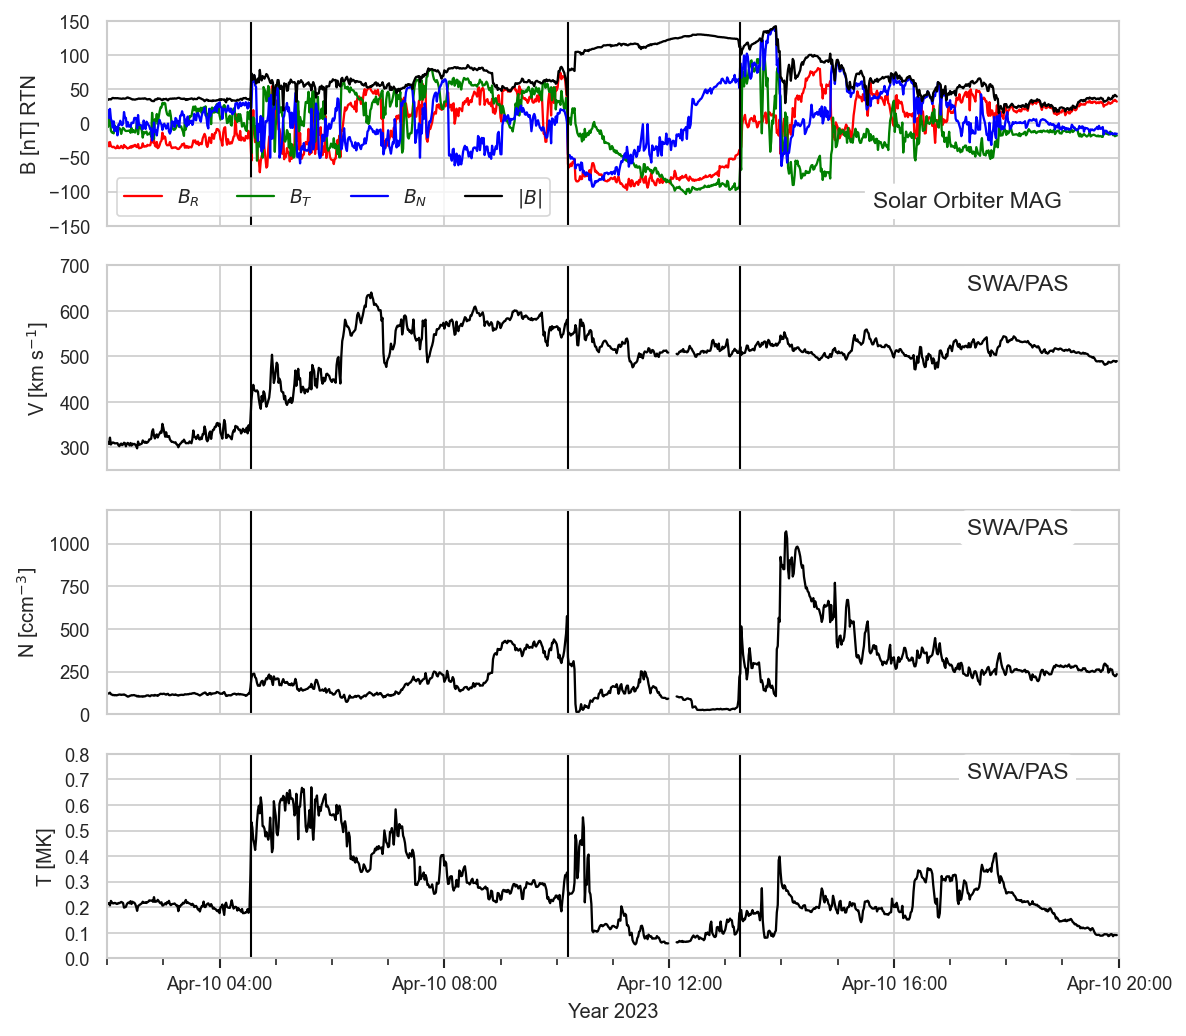

In [5]:
sns.set_style('whitegrid')
sns.set_context('paper')

fig=plt.figure(figsize=(8,7), dpi=150)

start=parse_time('2023-04-10 02:00').datetime
end=parse_time('2023-04-10 20:00').datetime

startind=np.where(start > solo.time)[0][-1]
endind=np.where(end > solo.time)[0][-1]

i=np.where(ic.icmecat_id=='ICME_SOLO_MOESTL_20230410_01')[0][0]

sc=solo[startind:endind]
print(start)
print(end)

lw=1.1

###################################

ax1 = plt.subplot(411) 

ax1.plot(sc.time,sc.bx,'-r',label='$B_{R}$',linewidth=lw)
ax1.plot(sc.time,sc.by,'-g',label='$B_{T}$',linewidth=lw)
ax1.plot(sc.time,sc.bz,'-b',label='$B_{N}$',linewidth=lw)
ax1.plot(sc.time,sc.bt,'-k',label='$|B|$',lw=lw)
    
######## plot vertical lines
ax1.plot([ic.icme_start_time[i],ic.icme_start_time[i]],[-500,500],'-k',linewidth=1)            
ax1.plot([ic.mo_start_time[i],ic.mo_start_time[i]],[-500,500],'-k',linewidth=1)            
ax1.plot([ic.mo_end_time[i],ic.mo_end_time[i]],[-500,500],'-k',linewidth=1)

plt.ylabel('B [nT] RTN')
plt.legend(loc=3,ncol=4,fontsize=9)
ax1.set_xlim(start,end)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b-%d') )
ax1.set_yticks(np.arange(-200,200,50))
ax1.set_ylim((-150, 150))

#ax1.set_xticklabels([]) does not work with sharex
#plt.setp(ax1.get_xticklabels(), fontsize=6)
plt.setp(ax1.get_xticklabels(), visible=False)

#########
ax2 = plt.subplot(412,sharex=ax1) 
ax2.plot(sc.time,sc.vt,'-k',label='V',linewidth=lw)

plt.ylabel('V [km s$^{-1}$]')
ax2.set_xlim(start,end)
ax2.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H') )
ax2.set_yticks(np.arange(0,1000,100))
#ax2.tick_params(axis="y", labelsize=12)
plt.ylim((250, 700))

#ax2.set_xticklabels([])
plt.setp(ax2.get_xticklabels(), visible=False)

ax2.plot([ic.icme_start_time[i],ic.icme_start_time[i]],[0,3000],'-k',linewidth=1)            
ax2.plot([ic.mo_start_time[i],ic.mo_start_time[i]],[0,3000],'-k',linewidth=1)            
ax2.plot([ic.mo_end_time[i],ic.mo_end_time[i]],[0,3000],'-k',linewidth=1)     

#########
ax3 = plt.subplot(413,sharex=ax1) 
ax3.plot(sc.time,sc.np,'-k',label='Np',linewidth=lw)

plt.ylabel('N [ccm$^{-3}]$')
ax3.set_xlim(start,end)
ax3.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H') )
plt.ylim((0, 1200))
#ax3.set_xticklabels([])
plt.setp(ax3.get_xticklabels(), visible=False)

#plot vertical lines
ax3.plot([ic.icme_start_time[i],ic.icme_start_time[i]],[0,10000],'-k',linewidth=1)
ax3.plot([ic.mo_start_time[i],  ic.mo_start_time[i]],  [0,10000],'-k',linewidth=1)
ax3.plot([ic.mo_end_time[i],ic.mo_end_time[i]],        [0,10000],'-k',linewidth=1)   


#############
ax4 = plt.subplot(414,sharex=ax1) 
ax4.plot(sc.time,sc.tp/1e6,'-k',label='Tp',linewidth=lw)

plt.ylabel('T [MK]')
ax4.set_xlim(start,end)
ax4.set_yticks(np.arange(0,1,0.1))
ax4.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H:00') )
plt.ylim((0, 0.8))

#plot vertical lines
ax4.plot([ic.icme_start_time[i],ic.icme_start_time[i]],[0,100],'-k',linewidth=1)            
ax4.plot([ic.mo_start_time[i],ic.mo_start_time[i]],[0,100],'-k',linewidth=1)            
ax4.plot([ic.mo_end_time[i],ic.mo_end_time[i]],[0,100],'-k',linewidth=1)            


ax1.annotate('Solar Orbiter MAG',xy=(0.85,0.09),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white') )
ax2.annotate('SWA/PAS',xy=(0.9,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax3.annotate('SWA/PAS',xy=(0.9,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax4.annotate('SWA/PAS',xy=(0.9,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

ax4.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax4.tick_params(which="both", bottom=True)
ax4.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax4.set_xlabel('Year 2023')

plt.tight_layout()

plotfile='results/fig2_solo_example.png'
plt.savefig(plotfile)
plotfile='results/fig2_solo_example.pdf'
plt.savefig(plotfile)

print('saved as ',plotfile)

### Figure (3) PSP magnetic fields close-to-Sun observations

Event 1 min distance during ICME 0.0632 ICME_PSP_MOESTL_20220905_01
Event 2 min distance during ICME 0.0705 ICME_PSP_MOESTL_20220602_01
Event 3 min distance during ICME 0.0892 ICME_PSP_MOESTL_20210430_01
Event 4 min distance during ICME 0.1354 ICME_PSP_MOESTL_20241222_01
Event 5 min distance during ICME 0.2056 ICME_PSP_MOESTL_20241004_01
Event 6 min distance during ICME 0.2187 ICME_PSP_MOESTL_20230313_01
0.2281
saved as  results/fig3_psp_close.pdf


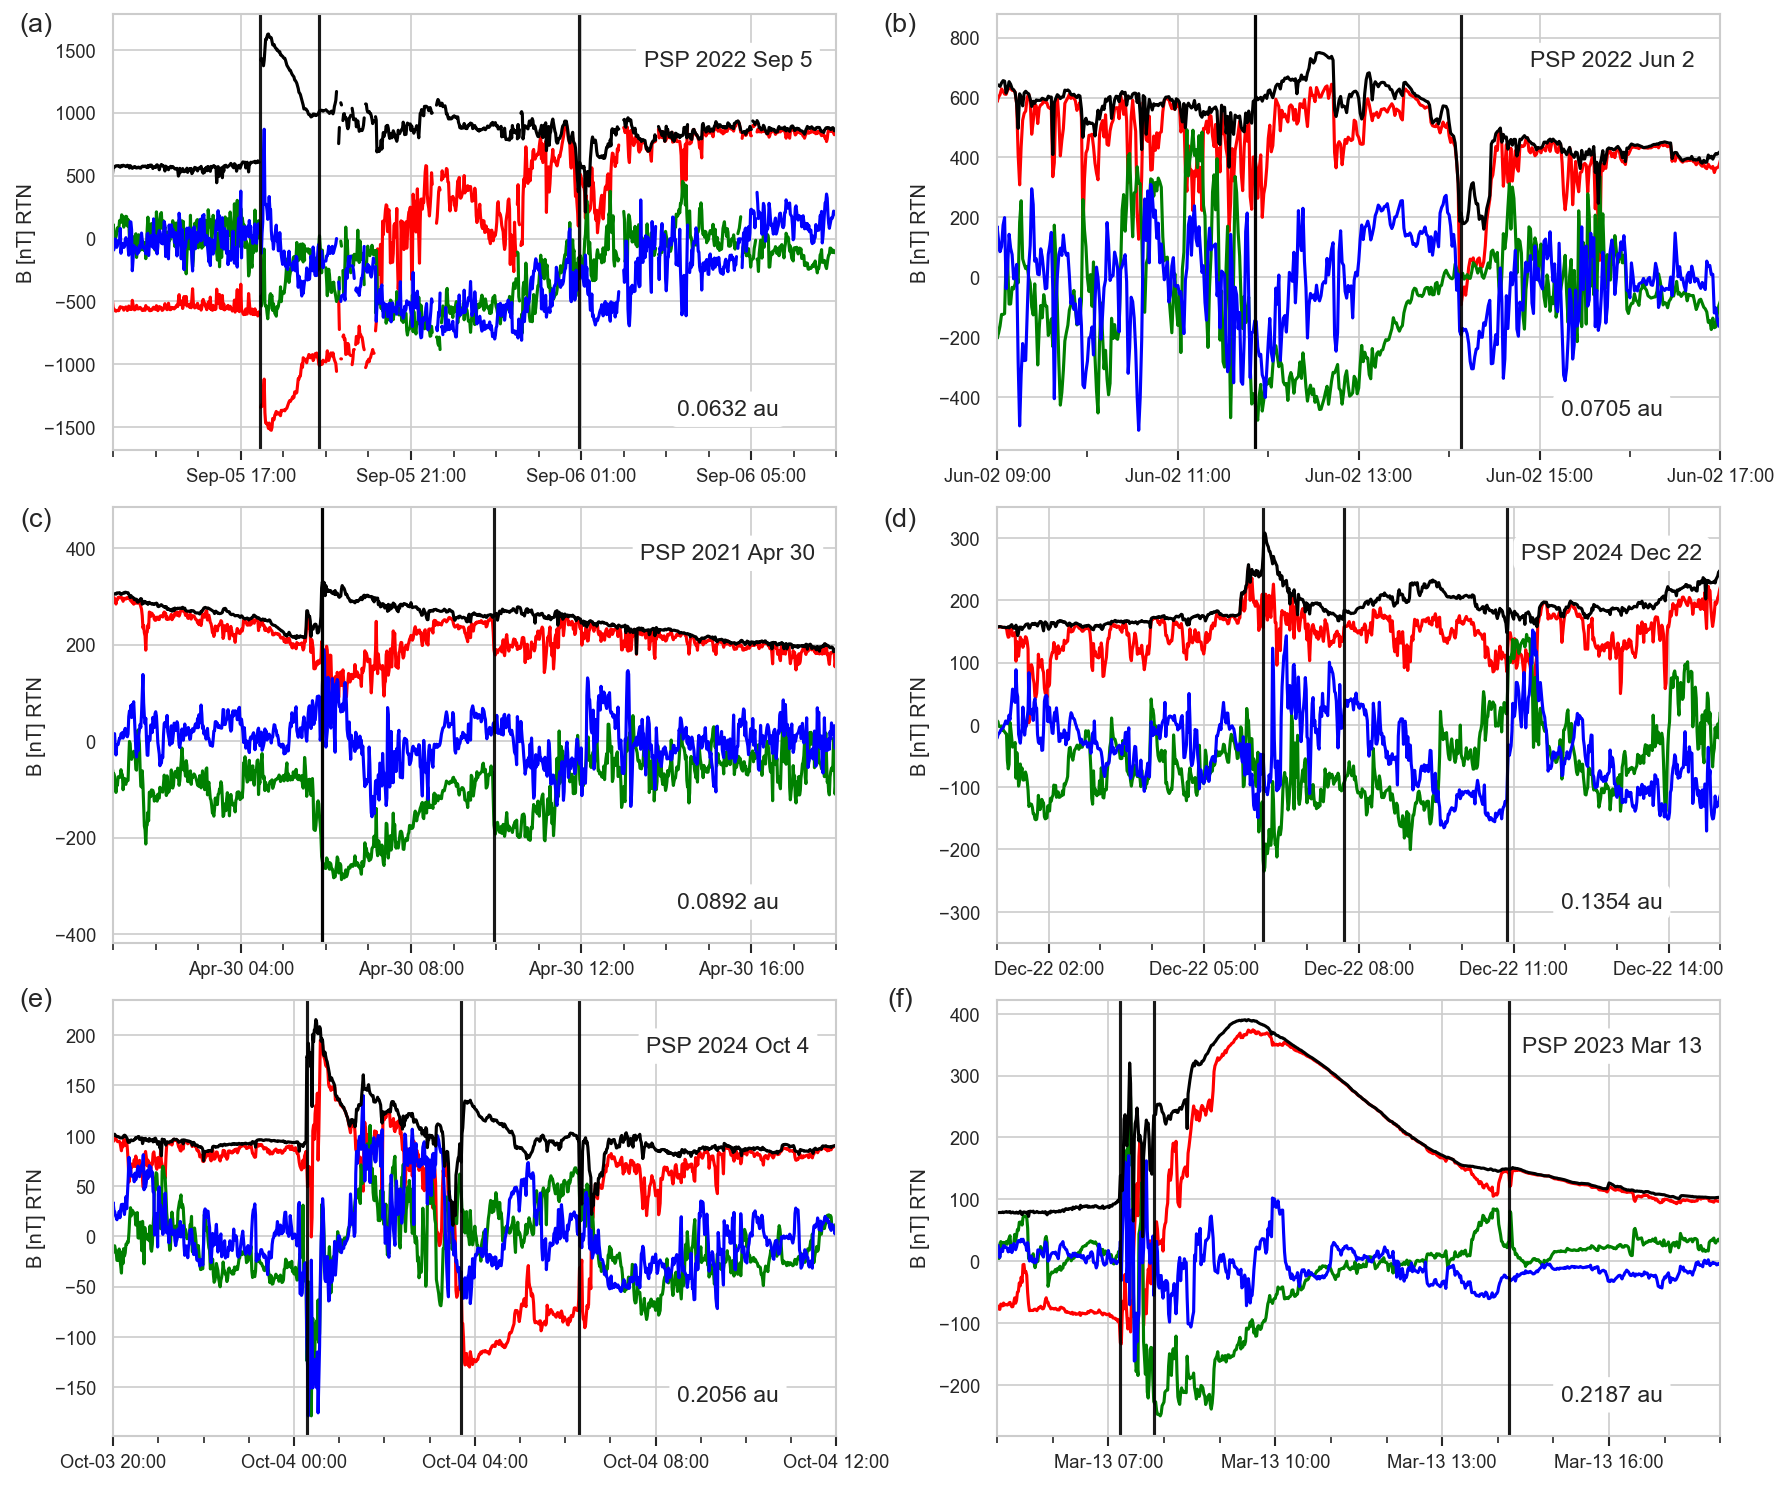

In [6]:
sns.set_style('whitegrid')
sns.set_context('paper')

fig=plt.figure(figsize=(12,10), dpi=150)

#these are the 6 closest PSP events from above
#462     ICME_PSP_MOESTL_20220905_01
#494     ICME_PSP_MOESTL_20220602_01
#624     ICME_PSP_MOESTL_20210430_01
#65      ICME_PSP_MOESTL_20241222_01
#103     ICME_PSP_MOESTL_20241004_01
#407     ICME_PSP_MOESTL_20230313_01


#extract PSP event data
i1=np.where(ic.icmecat_id=='ICME_PSP_MOESTL_20220905_01')[0][0]
starttime1=ic.icme_start_time[i1]
endtime1=ic.mo_end_time[i1]
startind1=np.where(starttime1 > psp.time)[0][-1]
endind1=np.where(endtime1 > psp.time)[0][-1]
sc1=psp[startind1-1000:endind1+1000]
print('Event 1 min distance during ICME',np.round(np.min(psp.r[startind1:endind1]),4), ic.icmecat_id[i1])

i2=np.where(ic.icmecat_id=='ICME_PSP_MOESTL_20220602_01')[0][0]
starttime2=ic.icme_start_time[i2]
endtime2=ic.mo_end_time[i2]
startind2=np.where(starttime2 > psp.time)[0][-1]
endind2=np.where(endtime2 > psp.time)[0][-1]
sc2=psp[startind2-1000:endind2+1000]
print('Event 2 min distance during ICME',np.round(np.min(psp.r[startind2:endind2]),4), ic.icmecat_id[i2])


i3=np.where(ic.icmecat_id=='ICME_PSP_MOESTL_20210430_01')[0][0]
starttime3=ic.icme_start_time[i3]
endtime3=ic.mo_end_time[i3]
startind3=np.where(starttime3 > psp.time)[0][-1]
endind3=np.where(endtime3 > psp.time)[0][-1]
sc3=psp[startind3-1500:endind3+1500]
print('Event 3 min distance during ICME',np.round(np.min(psp.r[startind3:endind3]),4),ic.icmecat_id[i3])


i4=np.where(ic.icmecat_id=='ICME_PSP_MOESTL_20241222_01')[0][0]
starttime4=ic.icme_start_time[i4]
endtime4=ic.mo_end_time[i4]
startind4=np.where(starttime4 > psp.time)[0][-1]
endind4=np.where(endtime4 > psp.time)[0][-1]
sc4=psp[startind4-1500:endind4+1500]
print('Event 4 min distance during ICME',np.round(np.min(psp.r[startind4:endind4]),4),ic.icmecat_id[i4])

i5=np.where(ic.icmecat_id=='ICME_PSP_MOESTL_20241004_01')[0][0]
starttime5=ic.icme_start_time[i5]
endtime5=ic.mo_end_time[i5]
startind5=np.where(starttime5 > psp.time)[0][-1]
endind5=np.where(endtime5 > psp.time)[0][-1]
sc5=psp[startind5-1500:endind5+1500]
print('Event 5 min distance during ICME',np.round(np.min(psp.r[startind5:endind5]),4),ic.icmecat_id[i5])

#i6=np.where(ic.icmecat_id=='ICME_PSP_MOESTL_20220912_01')[0][0]
i6=np.where(ic.icmecat_id=='ICME_PSP_MOESTL_20230313_01')[0][0]
starttime6=ic.icme_start_time[i6]
endtime6=ic.mo_end_time[i6]
startind6=np.where(starttime6 > psp.time)[0][-1]
endind6=np.where(endtime6 > psp.time)[0][-1]
sc6=psp[startind6-1500:endind6+1500]

min6=np.round(np.min(psp.r[startind6:endind6]),4)
print('Event 6 min distance during ICME',min6,ic.icmecat_id[i6])
print(ic.mo_sc_heliodistance[i6])



def plot_boundaries(ax,index):
    #plot vertical lines
    ax.axvline(ic.icme_start_time[index],color='black',linewidth=lw,alpha=al)
    ax.axvline(ic.mo_start_time[index],color='black',linewidth=lw,alpha=al)
    ax.axvline(ic.mo_end_time[index],color='black',linewidth=lw,alpha=al)

lw=1.5
al=0.9

#################################
ax1 = plt.subplot(321) 
ax1.plot(sc1.time,sc1.bx,'-r',label='$B_{R}$',linewidth=lw)
ax1.plot(sc1.time,sc1.by,'-g',label='$B_{T}$',linewidth=lw)
ax1.plot(sc1.time,sc1.bz,'-b',label='$B_{N}$',linewidth=lw)
ax1.plot(sc1.time,sc1.bt,'-k',label='$|B|$',lw=lw)
ax1.set_ylabel('B [nT] RTN')
ax1.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H:00') )
ax1.annotate('PSP 2022 Sep 5',xy=(0.85,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax1.annotate('0.0632 au',xy=(0.85,0.08),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
plot_boundaries(ax1,i1)
ax1.set_xlim(datetime.datetime(2022,9,5,14),datetime.datetime(2022,9,6,7))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax1.tick_params(which="both", bottom=True)


#################################
ax2 = plt.subplot(322) 
ax2.plot(sc2.time,sc2.bx,'-r',label='Bx',linewidth=lw)
ax2.plot(sc2.time,sc2.by,'-g',label='By',linewidth=lw)
ax2.plot(sc2.time,sc2.bz,'-b',label='Bz',linewidth=lw)
ax2.plot(sc2.time,sc2.bt,'-k',label='Btotal',lw=lw)
ax2.set_ylabel('B [nT] RTN')
ax2.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H:00') )
ax2.annotate('PSP 2022 Jun 2',xy=(0.85,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax2.annotate('0.0705 au',xy=(0.85,0.08),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
plot_boundaries(ax2,i2)
ax2.set_xlim(datetime.datetime(2022,6,2,9),datetime.datetime(2022,6,2,17))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax2.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax2.tick_params(which="both", bottom=True)

#################################
ax3 = plt.subplot(323) 

ax3.plot(sc3.time,sc3.bx,'-r',label='$B_{R}$',linewidth=lw)
ax3.plot(sc3.time,sc3.by,'-g',label='$B_{T}$',linewidth=lw)
ax3.plot(sc3.time,sc3.bz,'-b',label='$B_{N}$',linewidth=lw)
ax3.plot(sc3.time,sc3.bt,'-k',label='$|B|$',lw=lw)

ax3.set_ylabel('B [nT] RTN')
ax3.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H:00') )
ax3.annotate('PSP 2021 Apr 30',xy=(0.85,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax3.annotate('0.0892 au',xy=(0.85,0.08),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

plot_boundaries(ax3,i3)
ax3.set_xlim(datetime.datetime(2021,4,30,1),datetime.datetime(2021,4,30,18))
ax3.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax3.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax3.tick_params(which="both", bottom=True)


#################################
ax4 = plt.subplot(324) 
ax4.plot(sc4.time,sc4.bx,'-r',label='Bx',linewidth=lw)
ax4.plot(sc4.time,sc4.by,'-g',label='By',linewidth=lw)
ax4.plot(sc4.time,sc4.bz,'-b',label='Bz',linewidth=lw)
ax4.plot(sc4.time,sc4.bt,'-k',label='Btotal',lw=lw)

ax4.set_ylabel('B [nT] RTN')
ax4.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H:00') )
ax4.annotate('PSP 2024 Dec 22',xy=(0.85,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax4.annotate('0.1354 au',xy=(0.85,0.08),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

plot_boundaries(ax4,i4)
ax4.set_xlim(datetime.datetime(2024,12,22,1),datetime.datetime(2024,12,22,15))
ax4.set_ylim(-350,350)
ax4.tick_params(which="both", bottom=True)
ax4.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax4.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax4.tick_params(which="both", bottom=True)


#################################
ax5 = plt.subplot(325) 
ax5.plot(sc5.time,sc5.bx,'-r',label='Bx',linewidth=lw)
ax5.plot(sc5.time,sc5.by,'-g',label='By',linewidth=lw)
ax5.plot(sc5.time,sc5.bz,'-b',label='Bz',linewidth=lw)
ax5.plot(sc5.time,sc5.bt,'-k',label='Btotal',lw=lw)

ax5.set_ylabel('B [nT] RTN')
ax5.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H:00') )
ax5.annotate('PSP 2024 Oct 4',xy=(0.85,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax5.annotate('0.2056 au',xy=(0.85,0.08),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

plot_boundaries(ax5,i5)
ax5.set_xlim(datetime.datetime(2024,10,3,20),datetime.datetime(2024,10,4,12))
ax5.tick_params(which="both", bottom=True)
ax5.xaxis.set_major_locator(mdates.HourLocator(interval=4))
ax5.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax5.tick_params(which="both", bottom=True)


#################################
ax6 = plt.subplot(326) 
ax6.plot(sc6.time,sc6.bx,'-r',label='Bx',linewidth=lw)
ax6.plot(sc6.time,sc6.by,'-g',label='By',linewidth=lw)
ax6.plot(sc6.time,sc6.bz,'-b',label='Bz',linewidth=lw)
ax6.plot(sc6.time,sc6.bt,'-k',label='Btotal',lw=lw)

ax6.set_ylabel('B [nT] RTN')
ax6.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b-%d %H:00') )
ax6.annotate('PSP 2023 Mar 13',xy=(0.85,0.88),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))
ax6.annotate('0.2187 au',xy=(0.85,0.08),xycoords='axes fraction',fontsize=11,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

plot_boundaries(ax6,i6)
ax6.set_xlim(datetime.datetime(2023,3,13,5),datetime.datetime(2023,3,13,18))
ax6.tick_params(which="both", bottom=True)
ax6.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax6.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax6.tick_params(which="both", bottom=True)

##################
plt.tight_layout()

plt.annotate('(a)',xy=(0.02,0.97),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(b)',xy=(0.50,0.97),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(c)',xy=(0.02,0.64),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(d)',xy=(0.50,0.64),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(e)',xy=(0.02,0.32),xycoords='figure fraction',fontsize=13,ha='center')
plt.annotate('(f)',xy=(0.50,0.32),xycoords='figure fraction',fontsize=13,ha='center')


plotfile='results/fig3_psp_close.png'
plt.savefig(plotfile)
plotfile='results/fig3_psp_close.pdf'
plt.savefig(plotfile)

print('saved as ',plotfile)

## B(r) curve fits with power laws directly (B mean in magnetic obstacle)

#### Bmean in MO

results: for distance 

< 1.1 a and b are [10.742 -1.568] \
< 1.0 a and b are [10.71  -1.569]\
< 0.8 a and b are [10.67  -1.571] \
< 0.5 a and b are [10.24  -1.588] \
with all and Ulysses [10.74  -1.568] \
without Ulysses completely similar [10.741 -1.568]


B(r) for MO_Bmean
fit is done for  1972  events
start fit at 1 solar radii, in AU:  0.0047
LM, TRF dogbox methods power law parameters
[10.722 -1.569]
[10.722 -1.569]
[10.722 -1.569]
LM results in detail:
Parameters a and b, y = a x^b: [10.722 -1.569]
3 standard deviation on a and b [0.579 0.024]




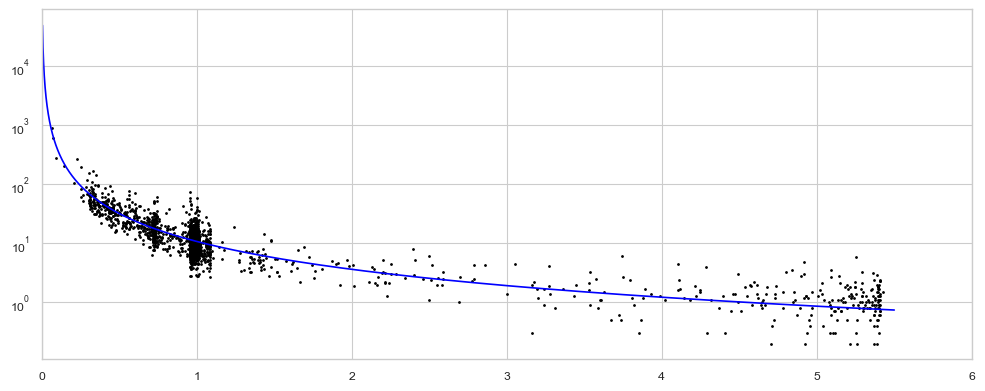

In [7]:
print('B(r) for MO_Bmean')

r=ic.mo_sc_heliodistance
b=ic.mo_bmean

#remove events where one or both are nan
rem=np.where(np.logical_or(np.isnan(r), np.isnan(b)))[0]
r=r.drop(rem)
b=b.drop(rem)

#remove ulysses because high latitude
#r=r.drop(iuly)
#b=b.drop(iuly)

#select distance range
ind1au=np.where(np.logical_and(ic.mo_sc_heliodistance < 6.0,ic.mo_sc_heliodistance > 0.0))[0]

rmean=r[ind1au]
bmean=b[ind1au]
#rmean=r
#bmean=b

print('fit is done for ',len(rmean),' events')

#plt.plot(rmean[ind1au],bmean[ind1au],'ok',ms=1)

#solar radius in au
#rs=1*const.R_sun/const.au
print('start fit at 1 solar radii, in AU: ',np.round(rs,4))
fitx=np.linspace(1*rs,5.5,num=10000)

#curve fit, no initial guess, all methods arrive at similar values
#Algorithm to perform minimization.
#‘trf’ : Trust Region Reflective algorithm, particularly suitable for large sparse problems with bounds. Generally robust method.
#‘dogbox’ : dogleg algorithm with rectangular trust regions, typical use case is small problems with bounds. Not recommended for problems with rank-deficient Jacobian.
#‘lm’ : Levenberg-Marquardt algorithm as implemented in MINPACK. Doesn’t handle bounds and sparse Jacobians. Usually the most efficient method for small unconstrained problems.
fit_lm=scipy.optimize.curve_fit(powerlaw, rmean,bmean,method='lm',full_output=True)
fit_trf=scipy.optimize.curve_fit(powerlaw, rmean,bmean,method='trf')
fit_dogbox=scipy.optimize.curve_fit(powerlaw, rmean,bmean,method='dogbox')

print('LM, TRF dogbox methods power law parameters')
print(np.round(fit_trf[0],3))
print(np.round(fit_lm[0],3))
print(np.round(fit_dogbox[0],3))

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# discussion of variance for MO Bmean
param=fit_lm[0]
pcov=fit_lm[1]
perr = np.sqrt(np.diag(pcov))
print('LM results in detail:')
print('Parameters a and b, y = a x^b:',np.round(param,3))
print('3 standard deviation on a and b', 3*np.round(perr,3))
print()
print()

#------plot 
fig=plt.figure(3,figsize=(12,10),dpi=100)
ax=plt.subplot(211)
ax.plot(rmean,bmean,'ok', markersize=1)
ax.set_yscale('log')
ax.set_xlim(0,6)
ax.plot(fitx,powerlaw(fitx,param[0],param[1]),'-b')


#### Bmax in MO

B(r) for MO_Bax
fit is done for  1972  events
LM, TRF dogbox methods power law parameters
[14.9228 -1.5305]
[14.9228 -1.5305]
[14.9228 -1.5305]
LM results in detail
Parameters a and b, y = a x^b: [14.9228 -1.5305]
3 standard deviation on a and b [0.8715 0.0282]




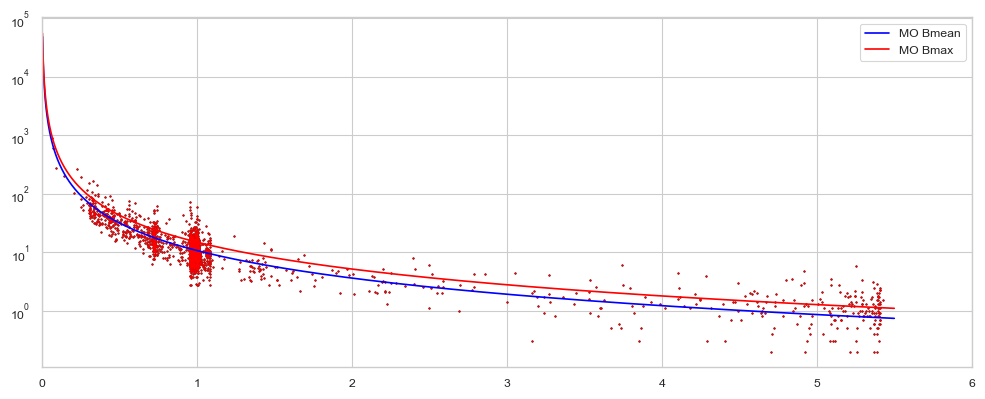

In [8]:
print('B(r) for MO_Bax')

r=ic.mo_sc_heliodistance
b=ic.mo_bmax

#remove events where one or both are nan
rem=np.where(np.logical_or(np.isnan(r), np.isnan(b)))[0]
r=r.drop(rem)
b=b.drop(rem)

#remove ulysses because high latitude
#r=r.drop(iuly)
#b=b.drop(iuly)

#select distance range
ind1au=np.where(np.logical_and(ic.mo_sc_heliodistance < 6.0,ic.mo_sc_heliodistance > 0.0))[0]

rmax=r[ind1au]
bmax=b[ind1au]
#rmean=r
#bmean=b

print('fit is done for ',len(rmean),' events')

#plt.plot(rmean[ind1au],bmean[ind1au],'ok',ms=1)
fit2_lm=scipy.optimize.curve_fit(powerlaw, rmax,bmax,method='lm',full_output=True)
fit2_trf=scipy.optimize.curve_fit(powerlaw, rmax,bmax,method='trf')
fit2_dogbox=scipy.optimize.curve_fit(powerlaw, rmax,bmax,method='dogbox')
print('LM, TRF dogbox methods power law parameters')
print(np.round(fit2_trf[0],4))
print(np.round(fit2_lm[0],4))
print(np.round(fit2_dogbox[0],4))

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# discussion of variance for MO Bmax
param2=fit2_lm[0]
pcov2=fit2_lm[1]
perr2 = np.sqrt(np.diag(pcov2))
print('LM results in detail')
print('Parameters a and b, y = a x^b:',np.round(param2,4))
print('3 standard deviation on a and b', 3*np.round(perr2,4))
print()
print()




#------plot 
fig=plt.figure(3,figsize=(12,10),dpi=100)
ax=plt.subplot(211)
ax.plot(rmean,bmean,'ok', markersize=0.5)
ax.plot(rmean,bmean,'or', markersize=0.5)
ax.set_yscale('log')
ax.set_xlim(0,6)
ax.plot(fitx,powerlaw(fitx,param[0],param[1]),'-b',label='MO Bmean')
ax.plot(fitx,powerlaw(fitx,param2[0],param2[1]),'-r',label='MO Bmax')
ax.legend()


### redo fit in log log space

for all up to 5.5 au
Slope: -1.4653 ± 0.0155
Intercept (nonlog): 10.1984 ± 0.0044

for up to 1.1 au
Slope: -1.5947 ± 0.0303
Intercept (nonlog): 9.9153 ± 0.0051

from 0.8 to 1.05 au
Slope: -1.4706 ± 0.3472
Intercept (nonlog): 9.9243 ± 0.0067


from 0 to 1.05 au
Slope: -1.5914 ± 0.0307
Intercept (nonlog): 9.9354 ± 0.0053


B(r) for MO_Bmean
fit is done for  1524  events
Slope: -1.5835 ± 0.0308
Intercept (nonlog): 9.9897 ± 0.0054
fit distance range 0 - 1.02  au


fit is done for  1972  events
Slope: -1.4653 ± 0.0155
Intercept (nonlog): 10.1984 ± 0.0044
fit distance range 0.0 - 6.0  au


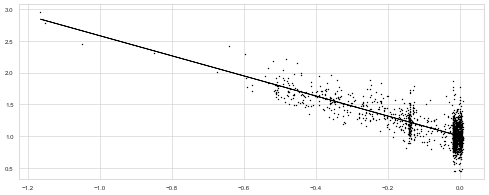

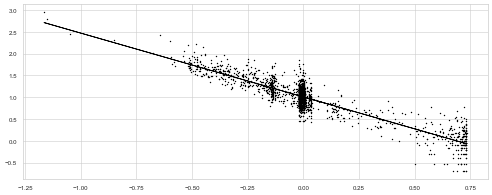

In [9]:
print('B(r) for MO_Bmean')


#print('start fit at 1 solar radii, in AU: ',np.round(rs,4))
fitx=np.linspace(1*rs,5.5,num=10000)

####linear fit 
def linear(x, k, d):
    return k * x + d


######################## fit 1
r=ic.mo_sc_heliodistance
b=ic.mo_bmean

#remove events where one or both are nan
rem=np.where(np.logical_or(np.isnan(r), np.isnan(b)))[0]
r=r.drop(rem)
b=b.drop(rem)

#remove ulysses because high latitude
#r=r.drop(iuly)
#b=b.drop(iuly)

#select distance range
mindistfit1=0
maxdistfit1=1.02 #(STEREO-B goes to < 1.09, Wind goes to < 1.02
ind1au=np.where(np.logical_and(ic.mo_sc_heliodistance < maxdistfit1,ic.mo_sc_heliodistance > mindistfit1))[0]

rmeanlog1=np.log10(r[ind1au])
bmeanlog1=np.log10(b[ind1au])
#rmean=r
#bmean=b

print('fit is done for ',len(rmeanlog1),' events')
#Fit with covariance matrix
params1, covariance1 = curve_fit(linear, rmeanlog1, bmeanlog1)
k1, d1 = params1
k1_err, d1_err = np.sqrt(np.diag(covariance1))
print(f"Slope: {k1:.4f} ± {k1_err:.4f}")
print(f"Intercept (nonlog): {10**d1:.4f} ± {d1_err:.4f}")
print('fit distance range',mindistfit1,'-',maxdistfit1,' au')
###################
print()
print()


######################## fit 2
r=ic.mo_sc_heliodistance
b=ic.mo_bmean

#remove events where one or both are nan
rem=np.where(np.logical_or(np.isnan(r), np.isnan(b)))[0]
r=r.drop(rem)
b=b.drop(rem)

#remove ulysses because high latitude
#r=r.drop(iuly)
#b=b.drop(iuly)

#select distance range
mindistfit2=0.0
maxdistfit2=6.0
ind1au=np.where(np.logical_and(ic.mo_sc_heliodistance < maxdistfit2,ic.mo_sc_heliodistance > mindistfit2))[0]

rmeanlog2=np.log10(r[ind1au])
bmeanlog2=np.log10(b[ind1au])
#rmean=r
#bmean=b

print('fit is done for ',len(rmeanlog2),' events')

# Fit with covariance matrix
params2, covariance2 = curve_fit(linear, rmeanlog2, bmeanlog2)
k2, d2 = params2
k2_err, d2_err = np.sqrt(np.diag(covariance2))
print(f"Slope: {k2:.4f} ± {k2_err:.4f}")
print(f"Intercept (nonlog): {10**d2:.4f} ± {d2_err:.4f}")
print('fit distance range',mindistfit2,'-',maxdistfit2,' au')


#------plot 
fig=plt.figure(3,figsize=(12,10),dpi=50)
ax=plt.subplot(211)
ax.plot(rmeanlog1,bmeanlog1,'ok', markersize=1)
ax.plot(rmeanlog1,linear(rmeanlog1,k1,d1),'-k')


#------plot 
fig=plt.figure(4,figsize=(12,10),dpi=50)
ax=plt.subplot(211)
ax.plot(rmeanlog2,bmeanlog2,'ok', markersize=1)
ax.plot(rmeanlog2,linear(rmeanlog2,k2,d2),'-k')

### Solar wind models

1.6450000000000002


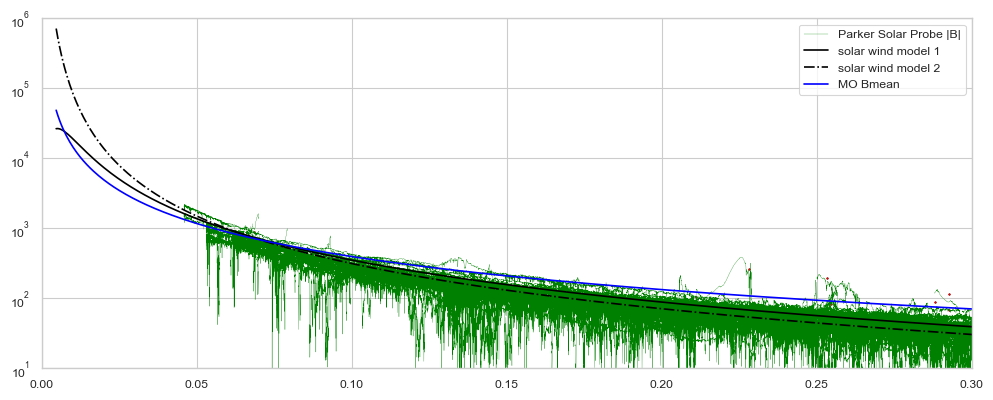

In [10]:
#Mann 2023 radial Btot solar wind model Parker 1958, from Mariani and Neubauer 1990

#equation 16
#units solar radii R
fitxrs=np.linspace(1*rs,5.5,num=10000)/rs
b0sw=(2.51+0.78)/2*1e5  #parameters B0 is in Gauss, Mann+ 2023  range 0.78−2.51 nT , use mean 
print(b0sw*1e-5)
asw=1.538 
Brsw=b0sw*fitxrs/((asw**2+fitxrs**2)**(3/2))

#equation 8
Brsw2=(6/fitxrs**3+1.18/fitxrs**2)*1e5


fig=plt.figure(5,figsize=(12,10),dpi=100)
ax=plt.subplot(211)
ax.plot(rmean,bmean,'ok', markersize=0.5)
ax.plot(rmean,bmean,'or', markersize=0.5)
ax.set_yscale('log')
ax.set_xlim(0,0.3)
ax.set_ylim(1e1,1e6)

ax.plot(psp.r,psp.bt,'-g',linewidth=0.2, label='Parker Solar Probe |B|')
ax.plot(fitx,Brsw,'k',label='solar wind model 1')
ax.plot(fitx,Brsw2,'k',linestyle='-.',label='solar wind model 2')

ax.plot(fitx,powerlaw(fitx,param[0],param[1]),'-b',label='MO Bmean')
ax.legend()



### Component fits, need to check

In [11]:
print('component fits, check what happens < 0')


print('Bz')

r=ic.mo_sc_heliodistance
bz=ic.mo_bzmean

rem=np.where(np.logical_or(np.isnan(r), np.isnan(bz)))[0]
r=r.drop(rem)
bz=bz.drop(rem)

fitbz_lm=scipy.optimize.curve_fit(powerlaw, r,np.abs(bz),method='lm',full_output=True)

parambz=fitbz_lm[0]
pcovbz=fitbz_lm[1]
perrbz = np.sqrt(np.diag(pcovbz))
print('LM results in detail')
print('Parameters a and b, y = a x^b:',np.round(parambz,2))
print('3 standard deviation on a and b', 3*np.round(perrbz,2))
print()
print()


##remove events where one or both are nan


print('By')

r=ic.mo_sc_heliodistance
by=ic.mo_bymean

rem=np.where(np.logical_or(np.isnan(r), np.isnan(by)))[0]
r=r.drop(rem)
by=by.drop(rem)

fitby_lm=scipy.optimize.curve_fit(powerlaw, r,np.abs(by),method='lm',full_output=True)

paramby=fitby_lm[0]
pcovby=fitby_lm[1]
perrby = np.sqrt(np.diag(pcovby))
print('LM results in detail')
print('Parameters a and b, y = a x^b:',np.round(paramby,2))
print('3 standard deviation on a and b', 3*np.round(perrby,2))
print()
print()



print('Bx')

r=ic.mo_sc_heliodistance
bx=ic.mo_bymean

rem=np.where(np.logical_or(np.isnan(r), np.isnan(bx)))[0]
r=r.drop(rem)
bx=bx.drop(rem)

fitbx_lm=scipy.optimize.curve_fit(powerlaw, r,np.abs(bx),method='lm',full_output=True)

parambx=fitbx_lm[0]
pcovbx=fitbx_lm[1]
perrbx = np.sqrt(np.diag(pcovbx))
print('LM results in detail')
print('Parameters a and b, y = a x^b:',np.round(parambx,2))
print('3 standard deviation on a and b', 3*np.round(perrbx,2))
print()
print()



################ plot components

component fits, check what happens < 0
Bz
LM results in detail
Parameters a and b, y = a x^b: [ 3.38 -1.57]
3 standard deviation on a and b [0.54 0.06]


By
LM results in detail
Parameters a and b, y = a x^b: [ 4.42 -1.61]
3 standard deviation on a and b [0.39 0.03]


Bx
LM results in detail
Parameters a and b, y = a x^b: [ 4.42 -1.61]
3 standard deviation on a and b [0.39 0.03]




### Figure (4) B(r) power laws

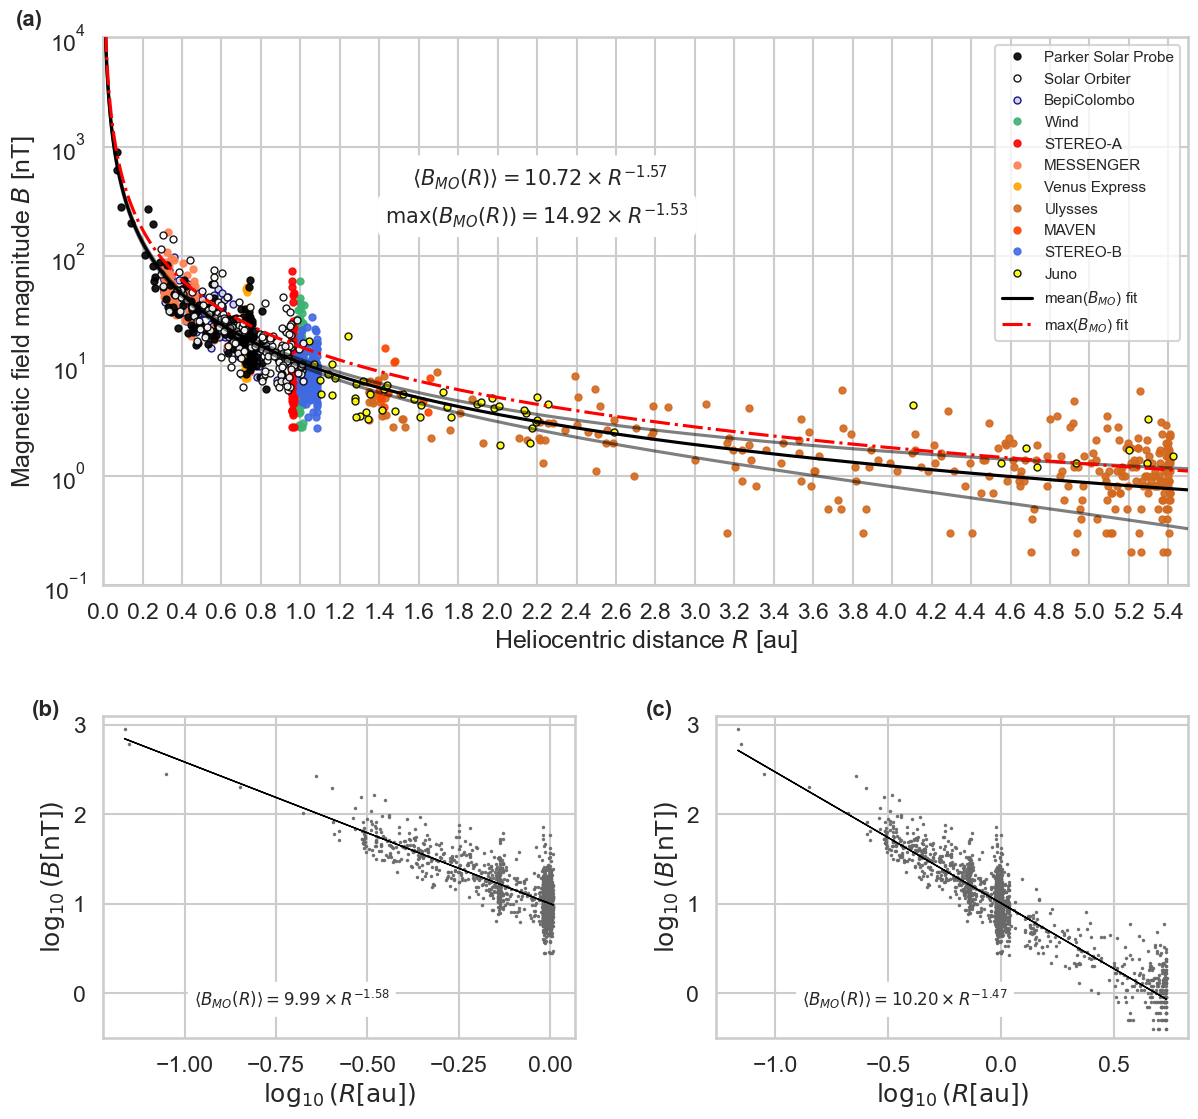

In [12]:
sns.set_context("talk")     
sns.set_style('whitegrid')

###############################################################################
fig=plt.figure(3,figsize=(14,13),dpi=100)


gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3,height_ratios=[1.7, 1])

##############################################################################
ax = fig.add_subplot(gs[0, :])
#plt.title('ICMECAT mean magnetic field in the magnetic obstacle')
ax.set_xlabel('Heliocentric distance $R$ [au]')
ax.set_ylabel('Magnetic field magnitude $B$ [nT]')

ax.plot(ic.mo_sc_heliodistance[ipsp],ic.mo_bmean[ipsp],'o',c='black', alpha=al,ms=ms, label='Parker Solar Probe',zorder=3)
ax.plot(ic.mo_sc_heliodistance[isol],ic.mo_bmean[isol],'o',c='black', markerfacecolor='white',alpha=al,ms=ms, label='Solar Orbiter',zorder=3)
ax.plot(ic.mo_sc_heliodistance[ibep],ic.mo_bmean[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms,label='BepiColombo')
ax.plot(ic.mo_sc_heliodistance[iwin],ic.mo_bmean[iwin],'o',c='mediumseagreen', alpha=al,ms=ms,label='Wind')
ax.plot(ic.mo_sc_heliodistance[ista],ic.mo_bmean[ista],'o',c='red', alpha=al,ms=ms, label='STEREO-A')

ax.plot(ic.mo_sc_heliodistance[imes],ic.mo_bmean[imes],'o',c='coral', alpha=al,ms=ms,label='MESSENGER')
ax.plot(ic.mo_sc_heliodistance[ivex],ic.mo_bmean[ivex],'o',c='orange', alpha=al,ms=ms,label='Venus Express')
ax.plot(ic.mo_sc_heliodistance[iuly],ic.mo_bmean[iuly],'o',c='chocolate', alpha=al,ms=ms, label='Ulysses')
ax.plot(ic.mo_sc_heliodistance[imav],ic.mo_bmean[imav],'o',c='orangered', alpha=al,ms=ms, label='MAVEN')
ax.plot(ic.mo_sc_heliodistance[istb],ic.mo_bmean[istb],'o',c='royalblue', alpha=al,ms=ms, label='STEREO-B')
ax.plot(ic.mo_sc_heliodistance[ijun],ic.mo_bmean[ijun],'o', c='black',markerfacecolor='yellow', alpha=al,ms=ms, label='Juno')
ax.text(-0.08, 1.05, '(a)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')


au_axis=np.arange(0,5.5,0.2)
ax.set_xticks(au_axis)
#ax3.tick_params(axis="x", labelsize=12)
ax.set_xlim([0,5.5])

ax.set_ylim([1e-1,1*1e4])
ax.set_yscale('log')

########### plot fits
ax.plot(fitx,powerlaw(fitx,param[0],param[1]),'-k', zorder=5, label='mean($B_{MO}$) fit')
#with errors 2 std
ax.plot(fitx,powerlaw(fitx,param[0]-2*perr[0],fit_lm[0][1])-2*perr[0],'-k',alpha=0.5, zorder=5)
ax.plot(fitx,powerlaw(fitx,param[0]+2*perr[0],fit_lm[0][1])+2*perr[0],'-k',alpha=0.5, zorder=5)
ax.plot(fitx,powerlaw(fitx,param2[0],param2[1]),'-.r', zorder=5, label='max($B_{MO}$) fit')

formulastring=r'$\langle B_{MO}(R) \rangle  = '+str(np.round(param[0],2))+r' \times R^{'+str(np.round(param[1],2))+'}$'
ax.annotate(formulastring,xy=(0.403,0.73),xycoords='axes fraction',fontsize=15,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

formulastring=r'$\max(B_{MO}(R)) = '+str(np.round(param2[0],2))+r' \times R^{'+str(np.round(param2[1],2))+'}$'
ax.annotate(formulastring,xy=(0.4,0.66),xycoords='axes fraction',fontsize=15,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

ax.legend(loc=1,fontsize=11)

############### Bottom left plot
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(rmeanlog1,bmeanlog1,'o', markersize=1.5, alpha=0.9, color='dimgrey')
ax2.plot(rmeanlog1,linear(rmeanlog1,k1,d1),'-k',linewidth=1)
ax2.set_ylim(-0.5,3.1)
ax2.set_xlabel(r'$\log_{10}(R \text{[au]})$')
ax2.set_ylabel(r'$\log_{10}(B \text{[nT]})$')
ax2.text(-0.15, 1.05, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')
strd=f'{np.round(10**d1, 2):.2f}'
formulastring=r'$\langle B_{MO}(R) \rangle ='+strd+r' \times R^{'+str(np.round(k1,2))+'}$'
ax2.annotate(formulastring,xy=(0.4,0.1),xycoords='axes fraction',fontsize=12,ha='center',bbox=dict(boxstyle='round', facecolor='white'))


############### Bottom right plot
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(rmeanlog2,bmeanlog2,'o', markersize=1.5, alpha=0.9,color='dimgrey')
ax3.plot(rmeanlog2,linear(rmeanlog2,k2,d2),'-k',linewidth=1)
ax3.set_ylim(-0.5,3.1)
ax3.set_xlabel(r'$\log_{10}(R \text{[au]})$')
ax3.set_ylabel(r'$\log_{10}(B \text{[nT]})$')
ax3.text(-0.15, 1.05, '(c)', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')

strd=f'{np.round(10**d2, 2):.2f}'
formulastring=r'$ \langle B_{MO}(R) \rangle ='+strd+r' \times R^{'+str(np.round(k2,2))+'}$'
ax3.annotate(formulastring,xy=(0.4,0.1),xycoords='axes fraction',fontsize=12,ha='center',bbox=dict(boxstyle='round', facecolor='white'))

#plt.tight_layout()

plt.savefig('results/fig4_br_mo.png', dpi=300,bbox_inches='tight')
plt.savefig('results/fig4_br_mo.pdf', dpi=300,bbox_inches='tight')

## Figure (5) connecting to solar observations

#### Power law with multipole expansion

B(r) for MO_Bmean
fit is done for  1972  events
start fit at 1 solar radii, in AU:  0.0047
10.548703433427791 2.022573620057919e-06
Results in detail:
Parameters a , y = a x^-1.57 + a1*x^-5:  [10.549  0.   ]
3 standard deviation on a and a1 [2.53739998e-01 1.17916527e-11]




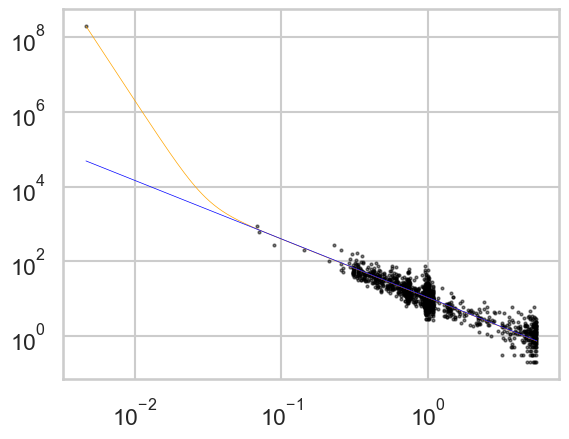

In [35]:
print('B(r) for MO_Bmean')

r=ic.mo_sc_heliodistance
b=ic.mo_bmean

#remove events where one or both are nan
rem=np.where(np.logical_or(np.isnan(r), np.isnan(b)))[0]
r=r.drop(rem)
b=b.drop(rem)

#remove ulysses because high latitude
#r=r.drop(iuly)
#b=b.drop(iuly)

#select distance range
ind1au=np.where(np.logical_and(ic.mo_sc_heliodistance < 6.0,ic.mo_sc_heliodistance > 0.0))[0]

rmean=np.array(r[ind1au])
bmean=np.array(b[ind1au])

print('fit is done for ',len(rmean),' events')
#solar radius in au
#rs=1*const.R_sun/const.au
print('start fit at 1 solar radii, in AU: ',np.round(rs,4))
fitx=np.linspace(1*rs,5.5,num=10000)


###### define AR point at 2 kg

gauss=1e5 #1 Gauss= 10^5 nT
#sunspot field strength at 1 solar radii
#https://link.springer.com/article/10.1007/s11207-006-0265-4
#average 2000 Gauss, or 0.2 Tesla, or 2 x 10^8 nT
sunspot_r=rs  
sunspot_b=2000*gauss              #general value for ARs fine?

#add to array for fitting
bmean=np.append(bmean,sunspot_b)
rmean=np.append(rmean,sunspot_r)

#def multipower(x,a,k,a1,k1,a2,k2):
#    return a*x**k + a1*x**k1 + a2*x**k2


def multipower(x,a,a1):
    return a*x**(-1.57) + a1*x**(-6) 

#def power(x,a,k):
#    return a*x**k
    
fit_dogbox10=scipy.optimize.curve_fit(multipower, rmean,bmean,method='lm',full_output=True)
param10=fit_dogbox10[0]
print(param10[0],param10[1])
pcov10=fit_dogbox10[1]
perr10 = np.sqrt(np.diag(pcov10))
print('Results in detail:')
print('Parameters a , y = a x^-1.57 + a1*x^-5: ',np.round(param10,3))
print('3 standard deviation on a and a1', 3*perr10)
print()
print()

plt.plot(rmean,bmean,'ok', ms=2,alpha=0.5)
plt.plot(fitx,multipower(fitx,param10[0],param10[1]),color='orange',linewidth=0.5,zorder=3)

plt.plot(fitx,powerlaw(fitx,param[0],param[1]),color='blue',linewidth=0.5,zorder=3)
#plt.plot(fitx,multipower(fitx,param10[0],param10[1],param10[2],param10[3],param10[4],param10[5]),'-b')
#plt.plot(fitx,power(fitx,param10[0],param10[1]),'-b')


#same fit in solar radii units?

plt.yscale('log')
plt.xscale('log')

### same for quiet Sun 


B(r) for MO_Bmean
fit is done for  1972  events
start fit at 1 solar radii, in AU:  0.0047
9.918300675457568 0.0021302104529633877
Results in detail:
Parameters a , y = a x^-1.57 + a1*x^-4:  [9.918e+00 2.000e-03]
3 standard deviation on a and a1 [2.54466846e-01 5.46803183e-07]




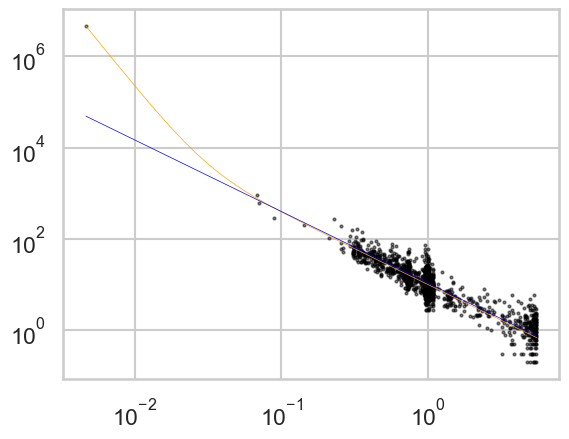

In [41]:
print('B(r) for MO_Bmean')

r=ic.mo_sc_heliodistance
b=ic.mo_bmean

#remove events where one or both are nan
rem=np.where(np.logical_or(np.isnan(r), np.isnan(b)))[0]
r=r.drop(rem)
b=b.drop(rem)

#remove ulysses because high latitude
#r=r.drop(iuly)
#b=b.drop(iuly)

#select distance range
ind1au=np.where(np.logical_and(ic.mo_sc_heliodistance < 6.0,ic.mo_sc_heliodistance > 0.0))[0]

rmean=np.array(r[ind1au])
bmean=np.array(b[ind1au])

print('fit is done for ',len(rmean),' events')
#solar radius in au
#rs=1*const.R_sun/const.au
print('start fit at 1 solar radii, in AU: ',np.round(rs,4))
fitx=np.linspace(1*rs,5.5,num=10000)


###### define quiet Sun point at 46 Gauss

gauss=1e5 #1 Gauss= 10^5 nT
#sunspot field strength at 1 solar radii
#https://link.springer.com/article/10.1007/s11207-006-0265-4
#average 2000 Gauss, or 0.2 Tesla, or 2 x 10^8 nT
sunspot_r=rs  
sunspot_b=46*gauss              #general value quiet sun

#add to array for fitting
bmean=np.append(bmean,sunspot_b)
rmean=np.append(rmean,sunspot_r)

#def multipower(x,a,k,a1,k1,a2,k2):
#    return a*x**k + a1*x**k1 + a2*x**k2


def multipower2(x,a,a1):
    return a*x**(-1.57) + a1*x**(-4) 

#def power(x,a,k):
#    return a*x**k
    
fit_dogbox20=scipy.optimize.curve_fit(multipower2, rmean,bmean,method='lm',full_output=True)
param20=fit_dogbox20[0]
print(param20[0],param20[1])
pcov20=fit_dogbox20[1]
perr20 = np.sqrt(np.diag(pcov20))
print('Results in detail:')
print('Parameters a , y = a x^-1.57 + a1*x^-4: ',np.round(param20,3))
print('3 standard deviation on a and a1', 3*perr20)
print()
print()

plt.plot(rmean,bmean,'ok', ms=2,alpha=0.5)
plt.plot(fitx,multipower2(fitx,param20[0],param20[1]),color='orange',linewidth=0.5,zorder=3)

plt.plot(fitx,powerlaw(fitx,param[0],param[1]),color='blue',linewidth=0.5,zorder=3)
#plt.plot(fitx,multipower2(fitx,param10[0],param10[1],param10[2],param10[3],param10[4],param10[5]),'-b')
#plt.plot(fitx,power(fitx,param10[0],param10[1]),'-b')


#same fit in solar radii units?

plt.yscale('log')
plt.xscale('log')

value of power law at 1 Rs from in situ
predicted field by MO power law at 1 Rs 0.49  Gauss
sunspot field: 2000.0 Gauss 
predicted field by MO power law at 1.3 Rs 0.32  Gauss
coronal loop field: 50.0 Gauss 



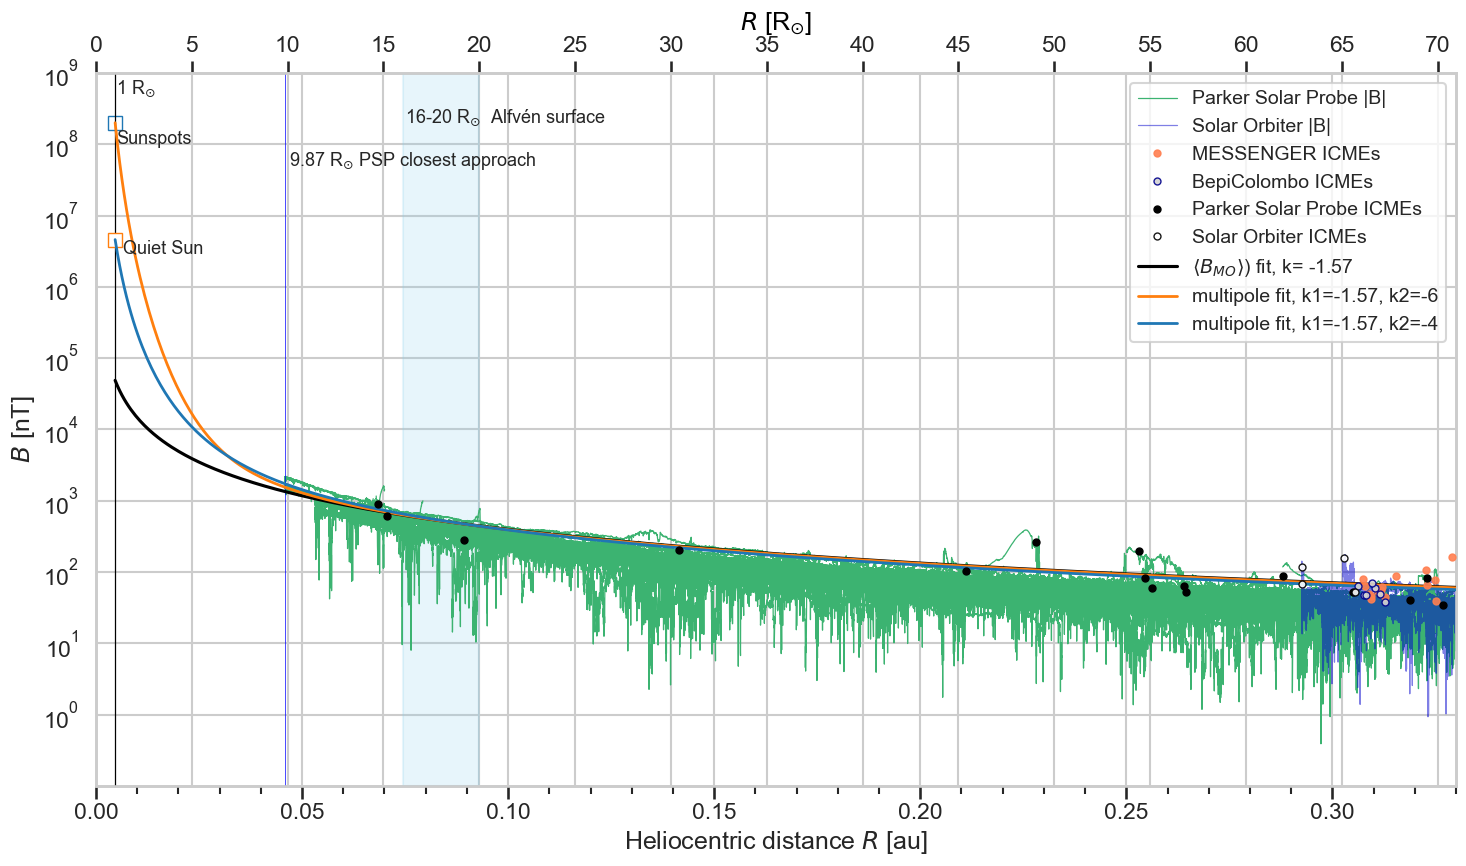

In [24]:
sns.set_context("talk")     
sns.set_style('whitegrid')

###############################################################################
fig=plt.figure(figsize=(15,9),dpi=100)

ax=plt.subplot(111)
#plt.title('ICME magnetic obstacle field compared to solar observations of active regions')
ax.set_xlabel('Heliocentric distance $R$ [au]')
ax.set_ylabel('$B$ [nT]')

#plot psp data Btotal
ax.plot(psp.r,psp.bt,color='mediumseagreen',linewidth=0.9, label='Parker Solar Probe |B|',alpha=1.0)
#plot SolO data Btotal
ax.plot(solo.r,solo.bt,color='mediumblue',linewidth=0.9, label='Solar Orbiter |B|',alpha=0.5)

ax.plot(ic.mo_sc_heliodistance[imes],ic.mo_bmean[imes],'o',c='coral', alpha=al,ms=ms,label='MESSENGER ICMEs', zorder=4)
ax.plot(ic.mo_sc_heliodistance[ibep],ic.mo_bmean[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms,label='BepiColombo ICMEs',zorder=4)
ax.plot(ic.mo_sc_heliodistance[ipsp],ic.mo_bmean[ipsp],'o',c='black', alpha=1.0,ms=ms, label='Parker Solar Probe ICMEs',zorder=4)
ax.plot(ic.mo_sc_heliodistance[isol],ic.mo_bmean[isol],'o',c='black', markerfacecolor='white',alpha=al,ms=ms, label='Solar Orbiter ICMEs',zorder=4)

ax.set_xticks(np.arange(0,0.5,0.05))
ax_max_x=0.33
ax.set_xlim([0,ax_max_x])

ax.set_yscale('log')
ax.set_yticks([1,10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9])
ax.set_ylim([0.1,10**9])

ax.grid(True, which='both', zorder=2)

##### create a second x-axis with solar radii
ax1 = ax.twiny()
ax1.set_xlabel('$R$ [R$_{\odot}$]', color='black')
#plot something in the solar radii scale but do not show it
ax1.plot(ic.mo_sc_heliodistance[ista]*scale, ic.mo_bmean[ista], '.',color=None)
ax1_ticks=np.arange(0,ax_max_x*scale,5)
ax1.set_xlim(0,ax_max_x*scale)
ax1.set_xticks(ax1_ticks)
#a 2nd axis grid is always in front of the data, for fix see bottom of https://github.com/matplotlib/matplotlib/issues/7984
ax1.set_zorder(-1)
ax.patch.set_visible(False)
ax1.patch.set_visible(True)

############## plot power law from fits, param is the bmean fit
ax.plot(fitx,powerlaw(fitx,param[0],param[1]),'-k',label=r'$\langle B_{MO} \rangle$) fit, k= -1.57', zorder=3)
#with errors 3 std
#ax3.plot(fitx,powerlaw(fitx,param[0]-3*perr[0],fit_lm[0][1])-3*perr[0],'--k',alpha=0.5)
#ax3.plot(fitx,powerlaw(fitx,param[0]+3*perr[0],fit_lm[0][1])+3*perr[0],'--k',alpha=0.5)

############## combined multipole power law to AR
ax.plot(fitx,multipower(fitx,param10[0],param10[1]),color='tab:orange',linewidth=2,zorder=3, label='multipole fit, k1=-1.57, k2=-6')


############## combined multipole power law to quiet Sun
ax.plot(fitx,multipower2(fitx,param20[0],param20[1]),color='tab:blue',linewidth=2,zorder=3, label='multipole fit, k1=-1.57, k2=-4')


########### solar wind model
#ax.plot(fitx,Brsw2,color='black',linestyle='-.',label='solar wind model')


####### # power laws with different exponents
#n3=-3
#const_quiet1=0.46
#ax.plot(fitx,powerlaw(fitx,const_quiet1,n3),color='tab:red',label='dipole field k=-3')

#active region with n-3
#const2=20
#ax.plot(fitx,powerlaw(fitx,const2,n3),'-b',label='coronal decay k=-3')

#active region with n-5
#n5=-5
#const3=5*1e-4
#ax.plot(fitx,powerlaw(fitx,const3,n5),'-r',label='coronal decay k=-5')


########################## add solar data points

gauss=1e5 #1 Gauss= 10^5 nT
#sunspot field strength at 1 solar radii
#https://link.springer.com/article/10.1007/s11207-006-0265-4
#average 2000 Gauss, or 0.2 Tesla, or 2 x 10^8 nT

sunspot_dist=const.R_sun/const.au #1 Rs correct
sunspot_b=2000*gauss              #general value for ARs fine?

### add coronal magnetic field
#https://iopscience.iop.org/article/10.3847/2041-8213/ac0c84/pdf
coronal_dist=1.3*const.R_sun/const.au  
coronal_b=50*gauss             

ax.plot(sunspot_dist,sunspot_b,marker='s', markerfacecolor='white',markersize='10')
#ax.plot(coronal_dist,coronal_b,marker='s', markerfacecolor='white',markersize='10')

#quiet sun 46 Gauss
quiet_dist1=1*rs   #1 Rs correct
quiet_b1=46*gauss              
ax.errorbar(quiet_dist1,quiet_b1,yerr=0,marker='s', markerfacecolor='white',markersize='10',capsize=5)

#vertical lines
ax.axvline(rs,linestyle='-', color='k', linewidth=0.9)
#ax.axvline(17*rs,linestyle='-', color='blue', linewidth=0.8)
#ax.axvline(3*rs,linestyle='--', color='k', linewidth=0.5)
ax.axvspan(16*rs, 20*rs, alpha=0.2, color='skyblue')


#PSP minimum orbit
psp_min=np.min(psp.r)
ax.axvline(psp_min,linestyle='-', color='b', linewidth=0.5)

###################### plot annotations
annotfs=13
ax.annotate(r'9.87 R$_{\odot}$ PSP closest approach',xy=(psp_min+0.001,5*1e7),xycoords='data',fontsize=annotfs,ha='left')
#ax.annotate('3 Rs',xy=(0.015,3*1e4),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('1 R$_{\odot}$',xy=(0.0048,5*1e8),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('16-20 R$_{\odot}$  Alfvén surface',xy=(16.1*rs,2*1e8),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('Sunspots',xy=(0.005,1e8),xycoords='data',fontsize=annotfs,ha='left',zorder=2)
#ax.annotate('Coronal loops',xy=(0.0065,3*1e6),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('Quiet Sun',xy=(0.0065,3*1e6),xycoords='data',fontsize=annotfs,ha='left')

ax.legend(fontsize=14,facecolor='white')
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
ax.tick_params(which="both", bottom=True)
#ax.set_minor_grid('off')
ax.grid(False, which='minor')

#########################
print('value of power law at 1 Rs from in situ')
print('predicted field by MO power law at 1 Rs',np.round(powerlaw(rs,param[0],param[1])/gauss,2), ' Gauss')
print('sunspot field:', sunspot_b/gauss, 'Gauss ')
print('predicted field by MO power law at 1.3 Rs',np.round(powerlaw(1.3*rs,param[0],param[1])/gauss,2), ' Gauss')
print('coronal loop field:', coronal_b/gauss, 'Gauss ')
print()


plt.tight_layout()

plt.savefig('results/fig5_br_mo_zoom.png', dpi=300,bbox_inches='tight')
plt.savefig('results/fig5_br_mo_zoom.pdf', dpi=300,bbox_inches='tight')

#### same with zoom in on close-in solar distances, for trying out power laws



value of power law at 1 Rs from in situ
predicted field by MO power law at 1 Rs 0.49  Gauss
sunspot field: 2000.0 Gauss 

predicted field by MO power law at 1.3 Rs 0.32  Gauss
coronal loop field: 50.0 Gauss 



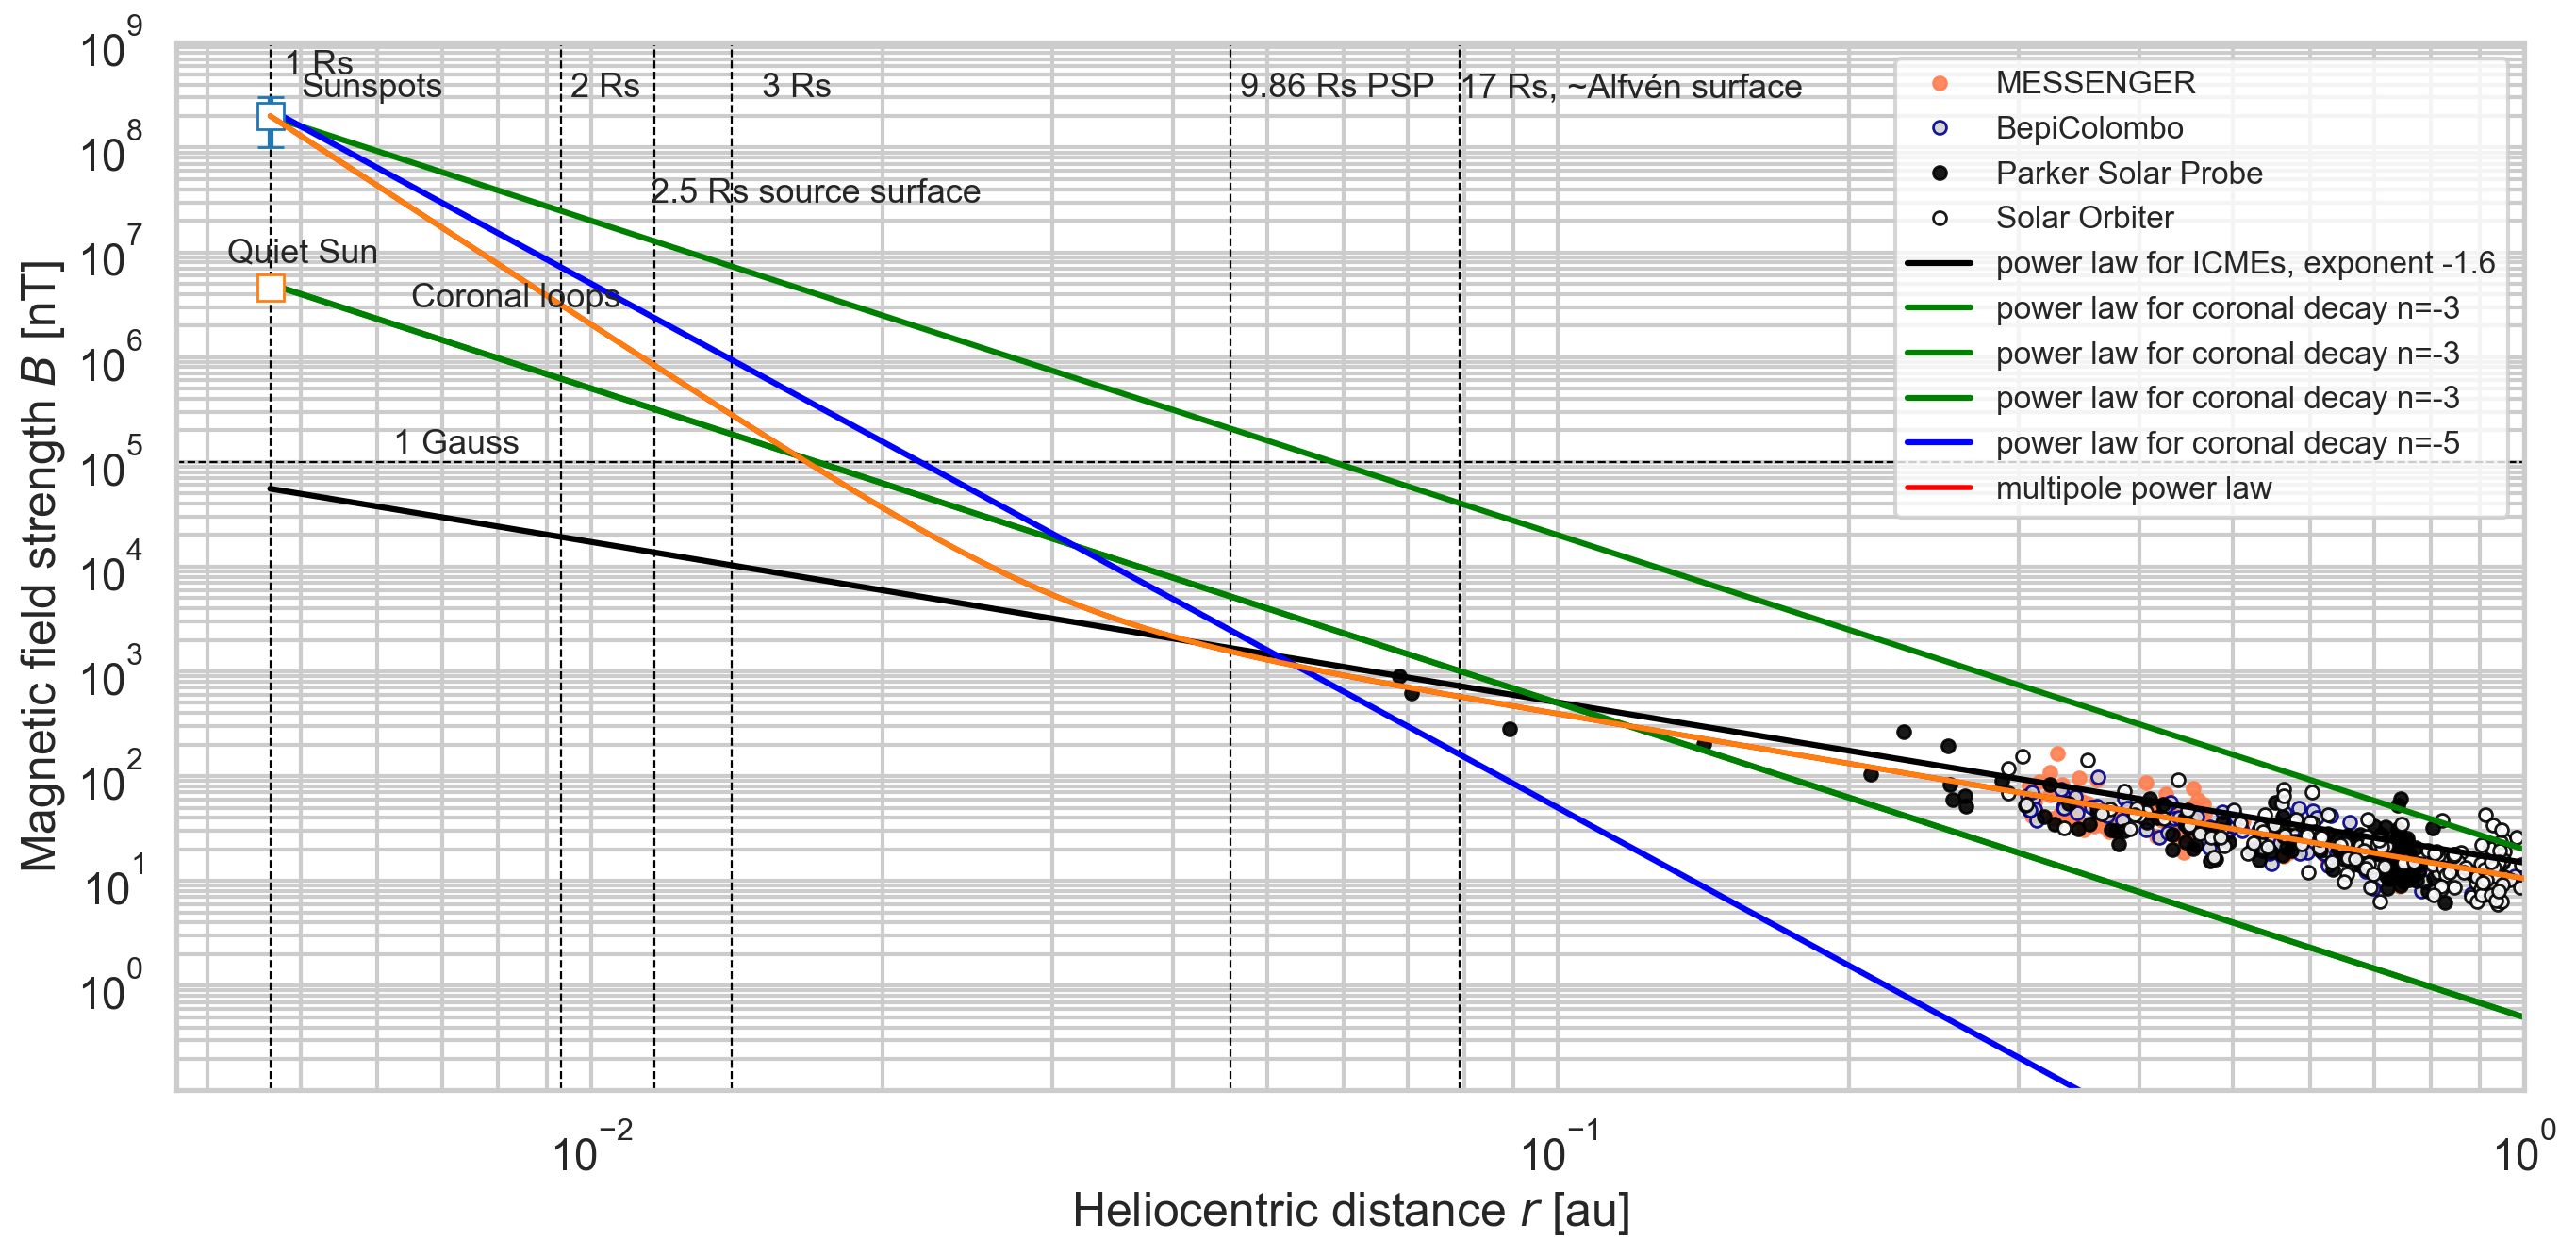

In [16]:
sns.set_context("talk")     
sns.set_style('whitegrid')

fig=plt.figure(figsize=(14,7),dpi=200)

ax=plt.subplot(111)
#plt.title('ICME magnetic obstacle field compared to solar observations of active regions')
ax.set_xlabel('Heliocentric distance $r$ [au]')
ax.set_ylabel('Magnetic field strength $B$ [nT]')


#plot psp data Btotal
#ax.plot(psp.r,psp.bt,'-g',linewidth=0.2, label='PSP Btot')
#plot SolO data Btotal
#ax.plot(solo.r,solo.bt,'-b',linewidth=0.2, label='SolO Btot')

ax.plot(ic.mo_sc_heliodistance[imes],ic.mo_bmean[imes],'o',c='coral', alpha=al,ms=ms,label='MESSENGER')
ax.plot(ic.mo_sc_heliodistance[ibep],ic.mo_bmean[ibep],'o',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms,label='BepiColombo')
ax.plot(ic.mo_sc_heliodistance[ipsp],ic.mo_bmean[ipsp],'o',c='black', alpha=al,ms=ms, label='Parker Solar Probe')
ax.plot(ic.mo_sc_heliodistance[isol],ic.mo_bmean[isol],'o',c='black', markerfacecolor='white',alpha=al,ms=ms, label='Solar Orbiter')


#x in AU
ax.set_xscale('log')
ax_min_x=rs*0.8
ax_max_x=1
ax.set_xlim([ax_min_x,ax_max_x])
#ax.set_xticks([1,2,3,4,5,6,10,20,30])


ax.set_yscale('log')
ax.set_yticks([1,10,10**2,10**3,10**4,10**5,10**6,10**7,10**8,10**9])
ax.set_ylim([0.1,10**9])

ax.grid(True, which='both', zorder=2)


######################## plot fits

#param2 is the ICME bmax fit

ax.plot(fitx,powerlaw(fitx,param2[0],param2[1]),'-k',label='power law for ICMEs, exponent -1.6')
#with errors 3 std
#ax3.plot(fitx,powerlaw(fitx,param[0]-3*perr[0],fit_lm[0][1])-3*perr[0],'--k',alpha=0.5)
#ax3.plot(fitx,powerlaw(fitx,param[0]+3*perr[0],fit_lm[0][1])+3*perr[0],'--k',alpha=0.5)



#ax3.set_ylim([1,10**9])

#vertical lines
ax.axvline(1*rs,linestyle='--', color='k', linewidth=0.8)
ax.axvline(2*rs,linestyle='--', color='k', linewidth=0.8)
ax.axvline(2.5*rs,linestyle='--', color='k', linewidth=0.8)
ax.axvline(3*rs,linestyle='--', color='k', linewidth=0.8)
ax.axvline(17*rs,linestyle='--', color='k', linewidth=0.8)


ax.axhline(1e5,linestyle='--', color='k', linewidth=0.8)

#PSP minimum orbit
psp_min=9.86*const.R_sun/const.au
ax.axvline(psp_min,linestyle='--', color='k', linewidth=0.8)


formulastring='$B_{MO}(r)='+str(np.round(param[0],2))+'r ^{'+str(np.round(param[1],2))+'}$'
#ax3.annotate(formulastring,xy=(0.4,0.6),xycoords='axes fraction',fontsize=20,ha='center')


#ax3.set_ylim([0,np.max(ic.mo_bmean)+50])
#ax3.set_yticks(np.arange(0,1000,10))
#ax3.set_ylim([0,1000])

#ax3.tick_params(axis="y", labelsize=12)

################################



print()
print()

print('value of power law at 1 Rs from in situ')

print('predicted field by MO power law at 1 Rs',np.round(powerlaw(rs,param[0],param[1])/gauss,2), ' Gauss')
print('sunspot field:', sunspot_b/gauss, 'Gauss ')

print()
print('predicted field by MO power law at 1.3 Rs',np.round(powerlaw(1.3*rs,param[0],param[1])/gauss,2), ' Gauss')
print('coronal loop field:', coronal_b/gauss, 'Gauss ')
print()



############## plot annotations

annotfs=13

ax.annotate('9.86 Rs PSP',xy=(psp_min+0.001,3*1e8),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('3 Rs',xy=(0.015,3*1e8),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('2.5 Rs source surface',xy=(0.0115,3*1e7),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('2 Rs',xy=(0.0095,3*1e8),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('1 Rs',xy=(0.0048,5*1e8),xycoords='data',fontsize=annotfs,ha='left')
ax.annotate('17 Rs, ~Alfvén surface',xy=(17*rs,3*1e8),xycoords='data',fontsize=annotfs,ha='left')

ax.annotate('Sunspots',xy=(0.005,3*1e8),xycoords='data',fontsize=annotfs,ha='left',zorder=5)
ax.annotate('Coronal loops',xy=(0.0065,3*1e6),xycoords='data',fontsize=annotfs,ha='left',zorder=5)

ax.annotate('Quiet Sun',xy=(0.0042,80*gauss),xycoords='data',fontsize=annotfs,ha='left',zorder=5)


ax.annotate('1 Gauss',xy=(1.3*0.0048,1.2*1e5),xycoords='data',fontsize=annotfs,ha='left')




#try out powerlaw from 1 Rs with -1, -2, -3 decay index n

n1=-1
n2=-2

#start from quiet Sun
n3=-3
const_quiet1=0.5

#n35=-3.5
#const_quiet1=0.03
ax.plot(fitx,powerlaw(fitx,const_quiet1,n3),'-g',label='power law for coronal decay n=-3')



########## solar wind model
ax.plot(fitx,powerlaw(fitx,const_quiet1,n3),'-g',label='power law for coronal decay n=-3')

#active region sunspots
const1=2*1e1
ax.plot(fitx,powerlaw(fitx,const1,n3),'-g',label='power law for coronal decay n=-3')

n5=-5
const2=5*1e-4
ax.plot(fitx,powerlaw(fitx,const2,n5),'-b',label='power law for coronal decay n=-5')

#n7=-7
#const2=1e-8
#ax.plot(fitx,powerlaw(fitx,const2,n7),'-y',label='power law for coronal decay n=-7')

#n9=-9
#const2=2*1e-13
#ax.plot(fitx,powerlaw(fitx,const2,n9),'-r',label='power law for coronal decay n=-9')

#combined power law
ax.plot(fitx,multipower(fitx,param10[0],param10[1]),color='red',linewidth=2,zorder=3, label='multipole power law')


ax.legend(fontsize=12,facecolor='white')


############## combined multipole power law
ax.plot(fitx,multipower(fitx,param10[0],param10[1]),color='tab:orange',linewidth=2,zorder=3, label='multipole fit, k1=-1.57, k2=-6')


########################## add solar data points

gauss=1e5 #1 Gauss= 10^5 nT


#sunspot field strength at 1 solar radii
#https://link.springer.com/article/10.1007/s11207-006-0265-4
#average 2000 Gauss
sunspot_dist1=1*rs   #1 Rs correct
sunspot_b1=2000*gauss              
#range 1000 - 3000 gauss
ax.errorbar(sunspot_dist1,sunspot_b1,yerr=1e3*gauss,marker='s', markerfacecolor='white',markersize='10',capsize=5)



#quiet sun 46 Gauss
#https://iopscience.iop.org/article/10.3847/2041-8213/ac0af2#:~:text=On%20average%2C%20the%20quiet%2DSun,a%20strength%20of%2046%20G.

quiet_dist1=1*rs   #1 Rs correct
quiet_b1=46*gauss              
ax.errorbar(quiet_dist1,quiet_b1,yerr=0,marker='s', markerfacecolor='white',markersize='10',capsize=5)



### add coronal magnetic field
#https://iopscience.iop.org/article/10.3847/2041-8213/ac0c84/pdf
coronal_dist1=1.3*rs 
coronal_b1=50*gauss  
#range 1-100 gauss

#ax.errorbar(coronal_dist1,coronal_b1,yerr=49*gauss,marker='s', markerfacecolor='white',markersize='10',capsize=5)

#https://iopscience.iop.org/article/10.3847/1538-4357/ac5b06
#height model 50 Mm
#rs_in_Mm=const.R_sun.value*1e-6
#print(rs_in_Mm)

plt.tight_layout()
plt.savefig('results/fig5_br_mo_zoom_close.png', dpi=150,bbox_inches='tight')